## **INFO 4300 - Predictive Analytics**
### **Class Project - World Bank Data Set, Modeling**
Jacob Shumway  

In [1]:
# Import libraries needed for analysis
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns
%matplotlib inline

In [2]:
# Fix random seed for consistency
np.random.seed(1111)

In [3]:
# Import data for analysis
analysis_data = pd.read_csv('https://raw.githubusercontent.com/jshumway0475/Predictive-Analytics/main/wb_clean_data_countries.csv')
analysis_data.drop(columns = 'Unnamed: 0', inplace = True)
analysis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2751 entries, 0 to 2750
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   economy            2751 non-null   object 
 1   time               2751 non-null   object 
 2   EG.ELC.ACCS.ZS     2751 non-null   float64
 3   EG.ELC.COAL.ZS     2751 non-null   float64
 4   EG.ELC.FOSL.ZS     2751 non-null   float64
 5   EG.ELC.HYRO.ZS     2751 non-null   float64
 6   EG.ELC.LOSS.ZS     2751 non-null   float64
 7   EG.ELC.NGAS.ZS     2751 non-null   float64
 8   EG.ELC.NUCL.ZS     2751 non-null   float64
 9   EG.ELC.PETR.ZS     2751 non-null   float64
 10  EG.ELC.RNWX.ZS     2751 non-null   float64
 11  EN.ATM.GHGT.KT.CE  2751 non-null   float64
 12  EN.ATM.METH.KT.CE  2751 non-null   float64
 13  NE.EXP.GNFS.ZS     2751 non-null   float64
 14  NE.IMP.GNFS.ZS     2751 non-null   float64
 15  NV.AGR.TOTL.ZS     2751 non-null   float64
 16  NV.IND.MANF.ZS     2751 

## **Question 3 - What can we do to continue to improve human flourishing while reducing greenhouse gas emissions?**
### Target variable: Categorical variable that represents groups binned by GDP per capita and greenhouse gas emissions per capita

In [4]:
analysis_data.columns

Index(['economy', 'time', 'EG.ELC.ACCS.ZS', 'EG.ELC.COAL.ZS', 'EG.ELC.FOSL.ZS',
       'EG.ELC.HYRO.ZS', 'EG.ELC.LOSS.ZS', 'EG.ELC.NGAS.ZS', 'EG.ELC.NUCL.ZS',
       'EG.ELC.PETR.ZS', 'EG.ELC.RNWX.ZS', 'EN.ATM.GHGT.KT.CE',
       'EN.ATM.METH.KT.CE', 'NE.EXP.GNFS.ZS', 'NE.IMP.GNFS.ZS',
       'NV.AGR.TOTL.ZS', 'NV.IND.MANF.ZS', 'NV.IND.TOTL.ZS', 'NV.SRV.TOTL.ZS',
       'NY.GDP.MKTP.CD', 'SP.DYN.LE00.FE.IN', 'SP.DYN.TFRT.IN', 'SP.POP.TOTL',
       'SP.URB.TOTL', 'year', 'gdp_per_capita', 'ghge_per_capita',
       'c2e_per_capita', 'urb_pop_pct'],
      dtype='object')

In [5]:
# Transform target variables in prepration for k-means
analysis_data['log_gdp_pc'] = np.log(analysis_data['gdp_per_capita'])
analysis_data['log_ghge_pc'] = np.log(analysis_data['ghge_per_capita'])
# Split the data set into predictors and target
X1 = analysis_data[['EG.ELC.ACCS.ZS', 'EG.ELC.COAL.ZS', 'EG.ELC.HYRO.ZS', 'EG.ELC.LOSS.ZS', 'EG.ELC.NGAS.ZS', 
                    'EG.ELC.NUCL.ZS', 'EG.ELC.PETR.ZS', 'EG.ELC.RNWX.ZS', 'NE.EXP.GNFS.ZS', 'NE.IMP.GNFS.ZS', 
                    'NV.AGR.TOTL.ZS', 'NV.IND.TOTL.ZS', 'NV.SRV.TOTL.ZS', 'SP.DYN.LE00.FE.IN', 'SP.DYN.TFRT.IN', 
                    'urb_pop_pct']]
y1 = analysis_data[['log_gdp_pc', 'log_ghge_pc']]

In [6]:
# Use k-means to create a target variable.
# Normalize the predictors in preparation for k-means
norm_y = StandardScaler().fit_transform(y1)
norm_y = pd.DataFrame(norm_y, columns = ['log_gdp_pc_norm', 'log_ghge_pc_norm'])

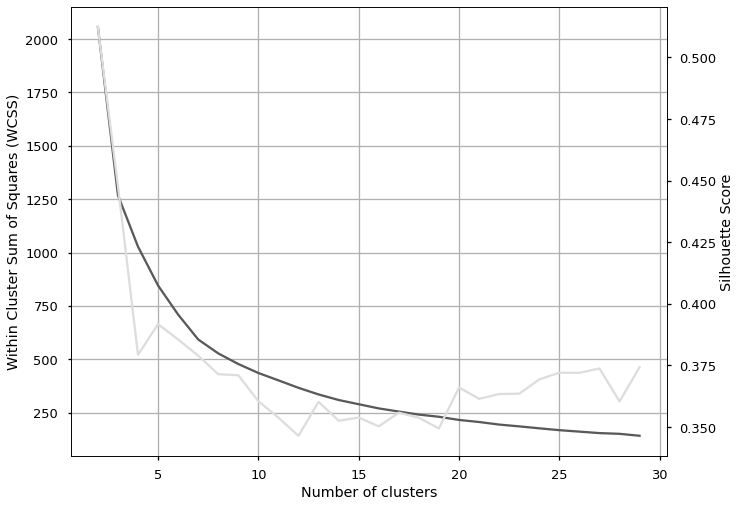

In [7]:
# Identify number of clusters to use in K-means using wcss-elbow method
# Select dataframe and columns to test
array = norm_y

# Elbow test
N = 30 # maximum number of clusters to test
wcss = []
silhouette = []

for n in range(2, N):
    kmeans = KMeans(n).fit(array)
    cluster_id = kmeans.fit_predict(array)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    score = metrics.silhouette_score(array, cluster_id, metric = 'euclidean')
    silhouette.append(score)

# Plot results
plt.style.use('seaborn-talk')
cluster_ct = range(2, N)
fig, ax1 = plt.subplots()
ax1.plot(cluster_ct, wcss, color = '#595959')
ax1.set_ylabel('Within Cluster Sum of Squares (WCSS)')
ax1.grid(True)
ax2 = ax1.twinx()
ax2.plot(cluster_ct, silhouette, color = '#DDDDDD')
ax2.set_ylabel('Silhouette Score')
ax2.grid(False)
ax1.set_xlabel('Number of clusters')
fig.tight_layout()

In [8]:
# Perform K-means calculations on selected array
clusters = KMeans(10).fit(array)
cluster_id = clusters.fit_predict(array)

# Add cluster id to dataframe
array['Cluster_ID'] = cluster_id

# Add untransformed variables to dataframe
array = pd.merge(array, y1, how = 'inner', left_index = True, right_index = True)
array.columns

Index(['log_gdp_pc_norm', 'log_ghge_pc_norm', 'Cluster_ID', 'log_gdp_pc',
       'log_ghge_pc'],
      dtype='object')

In [9]:
# Plot results of k-means
plt.figure(figsize = (10, 8))
sns.scatterplot(data = array, x = 'log_gdp_pc', y = 'log_ghge_pc', hue = 'Cluster_ID', palette = 'bright')
print(f'R2 = {round(array["log_gdp_pc"].corr(array["log_ghge_pc"])**2, 4)}')

R2 = 0.5733


## **Supervised Methods - Random Forest, kNN**

In [10]:
# Define target as Cluster_ID
y = array['Cluster_ID']

## **Random Forest model to predict Cluster_ID (combination of gdp_per_capita and ghge_per_capita)**

In [11]:
# Create testing and training data sets
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.25)

In [12]:
# Initiate model with 1000 decision trees
ideal_model_rf = RandomForestClassifier(n_estimators = 1000)
ideal_model_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [13]:
# Evaluate model accuracy using test dataset
y_pred_test = ideal_model_rf.predict(X_test)
y_pred_train = ideal_model_rf.predict(X_train)

In [14]:
# Evaluate model on training data
print(metrics.classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       180
           1       1.00      1.00      1.00       192
           2       1.00      1.00      1.00       354
           3       1.00      1.00      1.00       180
           4       1.00      1.00      1.00       335
           5       1.00      1.00      1.00       108
           6       1.00      1.00      1.00       204
           7       1.00      1.00      1.00       121
           8       1.00      1.00      1.00       187
           9       1.00      1.00      1.00       202

    accuracy                           1.00      2063
   macro avg       1.00      1.00      1.00      2063
weighted avg       1.00      1.00      1.00      2063



In [15]:
# Evaluate model on test data
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.87      0.95      0.90        55
           1       0.90      0.84      0.87        62
           2       0.86      0.89      0.88       104
           3       0.92      0.86      0.89        66
           4       0.95      0.97      0.96       116
           5       0.94      0.82      0.88        40
           6       0.78      0.88      0.83        57
           7       0.98      0.96      0.97        45
           8       0.90      0.92      0.91        71
           9       0.94      0.86      0.90        72

    accuracy                           0.90       688
   macro avg       0.90      0.90      0.90       688
weighted avg       0.90      0.90      0.90       688



In [16]:
# Create confusion matrix of test data
cm_test = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_test))
cm_test

0   1   2   3    4   5   6   7   8   9
0  52   0   0   3    0   0   0   0   0   0
1   0  52   0   0    3   0   6   0   0   1
2   0   0  93   0    0   1   3   0   6   1
3   6   0   2  57    0   0   0   0   1   0
4   0   1   0   0  113   0   0   1   0   1
5   0   0   5   0    0  33   2   0   0   0
6   0   2   3   0    0   1  50   0   0   1
7   0   1   0   0    1   0   0  43   0   0
8   2   0   2   2    0   0   0   0  65   0
9   0   2   3   0    2   0   3   0   0  62

In [17]:
# Determine variable importance for random forest model
importances = list(ideal_model_rf.feature_importances_)

# Create tuples with variable name and importance then sort by importance descending
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X1.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Create dataframe of feature importance and filter to variables with importance > 0
feature_importances_df = pd.DataFrame(feature_importances)
feature_importances_df.rename(columns = {0:'feature', 1:'importance'}, inplace = True)
feature_importances_df[feature_importances_df['importance'] > 0]

feature  importance
0      NV.AGR.TOTL.ZS        0.14
1   SP.DYN.LE00.FE.IN        0.11
2         urb_pop_pct        0.11
3      EG.ELC.ACCS.ZS        0.08
4      EG.ELC.LOSS.ZS        0.07
5      NV.SRV.TOTL.ZS        0.06
6      SP.DYN.TFRT.IN        0.06
7      EG.ELC.HYRO.ZS        0.05
8      EG.ELC.RNWX.ZS        0.05
9      NV.IND.TOTL.ZS        0.05
10     EG.ELC.COAL.ZS        0.04
11     EG.ELC.NGAS.ZS        0.04
12     EG.ELC.PETR.ZS        0.04
13     NE.EXP.GNFS.ZS        0.04
14     NE.IMP.GNFS.ZS        0.04
15     EG.ELC.NUCL.ZS        0.02

In [18]:
# Retrain model with constrained feature list based on initial model feature importance
feature_list = list(feature_importances_df[feature_importances_df['importance'] > 0.01]['feature'])
X2 = X1[feature_list]

# Create testing and training data sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size = 0.25)
print(X2_train.shape)
print(X2_test.shape)

(2063, 16)
(688, 16)


## **Random Forest Parameter Tuning**
### [Article on Medium that provides a good walkthrough](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d)
### [Another good article for perspective on overfitting](https://towardsdatascience.com/one-common-misconception-about-random-forest-and-overfitting-47cae2e2c23b)

Text(0.5, 0, 'n_estimators')

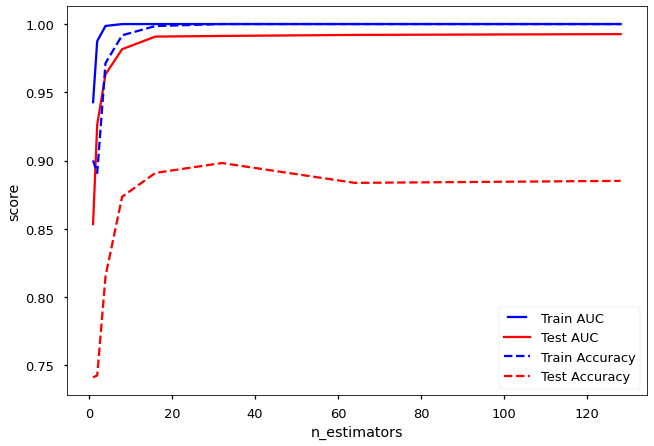

In [19]:
# Determine appropriate number of decision trees
n_estimators = [1, 2, 4, 8, 16, 32, 64, 128]
train_auc_results = []
test_auc_results = []
train_acc_results = []
test_acc_results = []
for estimator in n_estimators:
    rf_sens = RandomForestClassifier(n_estimators = estimator)
    rf_sens.fit(X2_train, y2_train)
    train_pred_sens = rf_sens.predict(X2_train)
    train_predprob_sens = rf_sens.predict_proba(X2_train)
    roc_auc_train = metrics.roc_auc_score(y2_train, train_predprob_sens, multi_class = 'ovo', average = 'weighted')
    train_auc_results.append(roc_auc_train)
    accuracy_train = metrics.accuracy_score(y2_train, train_pred_sens)
    train_acc_results.append(accuracy_train)
    test_pred_sens = rf_sens.predict(X2_test)
    test_predprob_sens = rf_sens.predict_proba(X2_test)
    roc_auc_test = metrics.roc_auc_score(y2_test, test_predprob_sens, multi_class = 'ovo', average = 'weighted')
    test_auc_results.append(roc_auc_test)
    accuracy_test = metrics.accuracy_score(y2_test, test_pred_sens)
    test_acc_results.append(accuracy_test)
line1, = plt.plot(n_estimators, train_auc_results, 'b', label = 'Train AUC')
line2, = plt.plot(n_estimators, test_auc_results, 'r', label = 'Test AUC')
line3, = plt.plot(n_estimators, train_acc_results, 'b--', label = 'Train Accuracy')
line4, = plt.plot(n_estimators, test_acc_results, 'r--', label = 'Test Accuracy')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 4)})
plt.ylabel('score')
plt.xlabel('n_estimators')

Text(0.5, 0, 'Tree Depth')

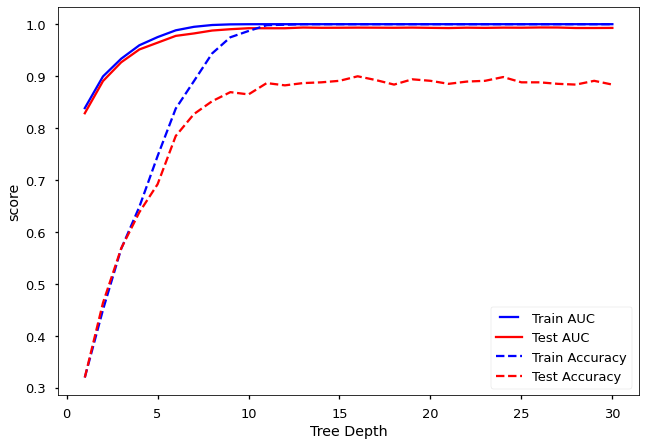

In [20]:
# Determine the approprate tree depth to avoid overfitting
max_depths = np.linspace(1, 30, 30, endpoint = True)
train_auc_results = []
test_auc_results = []
train_acc_results = []
test_acc_results = []
for max_depth in max_depths:
    rf_sens = RandomForestClassifier(max_depth = max_depth)
    rf_sens.fit(X2_train, y2_train)
    train_pred_sens = rf_sens.predict(X2_train)
    train_predprob_sens = rf_sens.predict_proba(X2_train)
    roc_auc_train = metrics.roc_auc_score(y2_train, train_predprob_sens, multi_class = 'ovo', average = 'weighted')
    train_auc_results.append(roc_auc_train)
    accuracy_train = metrics.accuracy_score(y2_train, train_pred_sens)
    train_acc_results.append(accuracy_train)
    test_pred_sens = rf_sens.predict(X2_test)
    test_predprob_sens = rf_sens.predict_proba(X2_test)
    roc_auc_test = metrics.roc_auc_score(y2_test, test_predprob_sens, multi_class = 'ovo', average = 'weighted')
    test_auc_results.append(roc_auc_test)
    accuracy_test = metrics.accuracy_score(y2_test, test_pred_sens)
    test_acc_results.append(accuracy_test)
line1, = plt.plot(max_depths, train_auc_results, 'b', label = 'Train AUC')
line2, = plt.plot(max_depths, test_auc_results, 'r', label = 'Test AUC')
line3, = plt.plot(max_depths, train_acc_results, 'b--', label = 'Train Accuracy')
line4, = plt.plot(max_depths, test_acc_results, 'r--', label = 'Test Accuracy')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 4)})
plt.ylabel('score')
plt.xlabel('Tree Depth')

In [21]:
# Initiate model with 20 decision trees but leaving max_depth at default
ideal_model_rf2 = RandomForestClassifier(n_estimators = 20)
ideal_model_rf2.fit(X2_train, y2_train)

RandomForestClassifier(n_estimators=20)

In [22]:
# Evaluate model accuracy using test dataset
y2_pred_test = ideal_model_rf2.predict(X2_test)
y2_pred_prob_test = ideal_model_rf2.predict_proba(X2_test)
y2_pred_train = ideal_model_rf2.predict(X2_train)

In [23]:
# Evaluate model on training data
print(metrics.classification_report(y2_train, y2_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       166
           1       1.00      1.00      1.00       199
           2       1.00      1.00      1.00       348
           3       1.00      1.00      1.00       174
           4       1.00      1.00      1.00       333
           5       1.00      1.00      1.00       118
           6       1.00      1.00      1.00       194
           7       1.00      1.00      1.00       127
           8       1.00      1.00      1.00       203
           9       1.00      1.00      1.00       201

    accuracy                           1.00      2063
   macro avg       1.00      1.00      1.00      2063
weighted avg       1.00      1.00      1.00      2063



In [24]:
# Evaluate model on test data
print(metrics.classification_report(y2_test, y2_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90        69
           1       0.88      0.91      0.89        55
           2       0.85      0.88      0.87       110
           3       0.92      0.82      0.87        72
           4       0.93      0.97      0.95       118
           5       0.78      0.83      0.81        30
           6       0.86      0.73      0.79        67
           7       1.00      0.97      0.99        39
           8       0.92      0.87      0.90        55
           9       0.86      0.86      0.86        73

    accuracy                           0.89       688
   macro avg       0.88      0.88      0.88       688
weighted avg       0.89      0.89      0.88       688



In [25]:
# Create confusion matrix of test data
cm_test2 = pd.DataFrame(metrics.confusion_matrix(y2_test, y2_pred_test))
cm_test2

0   1   2   3    4   5   6   7   8   9
0  66   0   0   2    0   0   0   0   1   0
1   0  50   0   0    3   0   2   0   0   0
2   0   0  97   2    0   2   2   0   2   5
3   9   0   3  59    0   0   0   0   1   0
4   0   3   0   0  114   0   0   0   0   1
5   0   0   3   0    0  25   2   0   0   0
6   0   2   7   0    0   5  49   0   0   4
7   0   1   0   0    0   0   0  38   0   0
8   3   0   3   1    0   0   0   0  48   0
9   0   1   1   0    6   0   2   0   0  63

In [26]:
# Determine variable importance for random forest model
importances2 = list(ideal_model_rf2.feature_importances_)

# Create tuples with variable name and importance then sort by importance descending
feature_importances2 = [(feature, round(importance, 2)) for feature, importance in zip(X2.columns, importances2)]
feature_importances2 = sorted(feature_importances2, key = lambda x: x[1], reverse = True)

# Create dataframe of feature importance and filter to variables with importance > 0
feature_importances_df2 = pd.DataFrame(feature_importances2)
feature_importances_df2.rename(columns = {0:'feature', 1:'importance'}, inplace = True)
feature_importances_df2[feature_importances_df2['importance'] > 0]

feature  importance
0      NV.AGR.TOTL.ZS        0.13
1   SP.DYN.LE00.FE.IN        0.11
2         urb_pop_pct        0.10
3      EG.ELC.ACCS.ZS        0.07
4      EG.ELC.LOSS.ZS        0.07
5      NV.SRV.TOTL.ZS        0.07
6      EG.ELC.HYRO.ZS        0.06
7      SP.DYN.TFRT.IN        0.05
8      NV.IND.TOTL.ZS        0.05
9      EG.ELC.NGAS.ZS        0.05
10     EG.ELC.PETR.ZS        0.05
11     NE.EXP.GNFS.ZS        0.05
12     EG.ELC.RNWX.ZS        0.04
13     EG.ELC.COAL.ZS        0.04
14     NE.IMP.GNFS.ZS        0.04
15     EG.ELC.NUCL.ZS        0.02

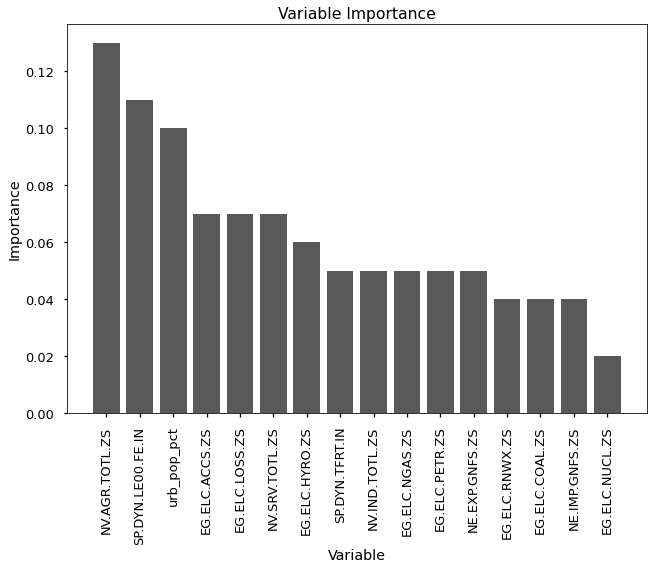

In [27]:
# list of x locations for plotting
x_values = list(range(len(feature_importances_df2['importance'])))
# Make a bar chart
plt.bar(x_values, feature_importances_df2['importance'], orientation = 'vertical', color = '#595959')
# Tick labels for x axis
plt.xticks(x_values, list(feature_importances_df2['feature']), rotation = 'vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importance');

In [28]:
# build roc curve for Random Forest
fpr = {}
tpr = {}
thresh = {}
n_class = len(list(set(y2_test)))
plt.figure(figsize = (10, 8))
for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y2_test, y2_pred_prob_test[:,i], pos_label = i)
    plt.plot(fpr[i], tpr[i], linestyle = '--', label = (f'Class {i} vs Rest'))
plt.title('Random Forest Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc = 'best');
rf_roc_score = round(metrics.roc_auc_score(y2_test, y2_pred_prob_test, multi_class = 'ovo', average = 'weighted'), 3)
print(f'auc score = {rf_roc_score}')

auc score = 0.99


## **kNN model to predict Cluster_ID (combination of gdp_per_capita and ghge_per_capita)**

In [29]:
# Normalize data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Minimum error:- 0.09156976744186046 at K = 1


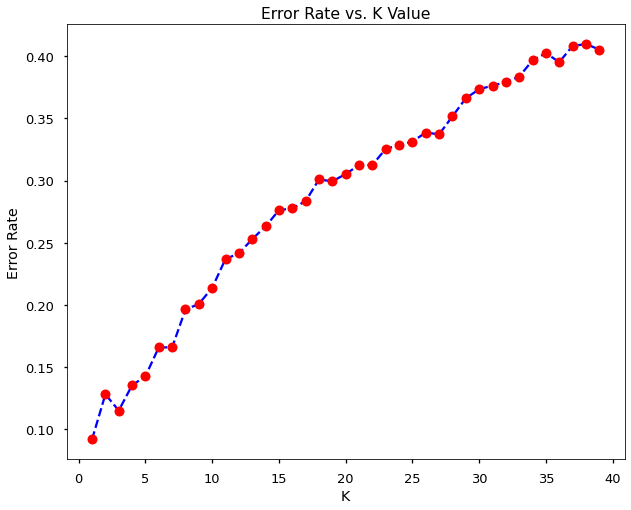

In [30]:
# Identify the best value of k
error_rate = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,8))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)) + 1)

In [31]:
# Initiate model with k = 3
ideal_model_knn = KNeighborsClassifier(n_neighbors = 3)
ideal_model_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [32]:
# Evaluate model accuracy using test dataset
y3_pred_test = ideal_model_knn.predict(X_test)
y3_pred_prob_test = ideal_model_knn.predict_proba(X_test)
y3_pred_train = ideal_model_knn.predict(X_train)

In [33]:
# Evaluate model
print(metrics.classification_report(y_test, y3_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89        55
           1       0.95      0.85      0.90        62
           2       0.85      0.85      0.85       104
           3       0.90      0.85      0.88        66
           4       0.94      0.97      0.96       116
           5       0.91      0.78      0.84        40
           6       0.79      0.88      0.83        57
           7       0.98      0.98      0.98        45
           8       0.81      0.92      0.86        71
           9       0.88      0.82      0.85        72

    accuracy                           0.89       688
   macro avg       0.89      0.88      0.88       688
weighted avg       0.89      0.89      0.89       688



In [34]:
# Create confusion matrix of test data
cm_test3 = pd.DataFrame(metrics.confusion_matrix(y_test, y3_pred_test))
cm_test3

0   1   2   3    4   5   6   7   8   9
0  50   0   0   4    0   0   0   0   1   0
1   0  53   0   0    5   0   3   0   0   1
2   0   0  88   0    0   0   0   0  12   4
3   6   0   2  56    0   0   0   0   2   0
4   0   0   0   0  113   0   0   1   0   2
5   0   0   6   0    0  31   3   0   0   0
6   0   1   3   0    0   2  50   0   0   1
7   0   1   0   0    0   0   0  44   0   0
8   1   0   2   2    0   1   0   0  65   0
9   0   1   3   0    2   0   7   0   0  59

In [35]:
# build roc curve for kNN
fpr2 = {}
tpr2 = {}
thresh2 = {}
n_class = len(list(set(y_test)))
plt.figure(figsize = (10, 8))
for i in range(n_class):
    fpr2[i], tpr2[i], thresh2[i] = metrics.roc_curve(y_test, y3_pred_prob_test[:,i], pos_label = i)
    plt.plot(fpr2[i], tpr2[i], linestyle = '--', label = (f'Class {i} vs Rest'))
plt.title('kNN Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc = 'best');
kNN_roc_score = round(metrics.roc_auc_score(y_test, y3_pred_prob_test, multi_class = 'ovo', average = 'weighted'), 3)
print(f'auc score = {kNN_roc_score}')

auc score = 0.976


In [36]:
# Explain RF model predictions using SHAP, running model takes about 2 to 5 mins for test data set
run_model = 1
if run_model == 1:
    shap.initjs()
    explainer = shap.TreeExplainer(ideal_model_rf2)
    expected_value = explainer.expected_value
    shap_values = explainer.shap_values(X2_test)

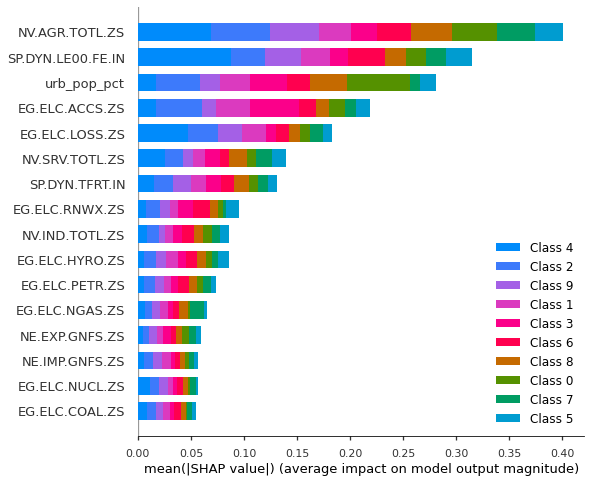

In [37]:
shap.summary_plot(shap_values, X2_test)

cluster_id =  0


cluster_id =  1


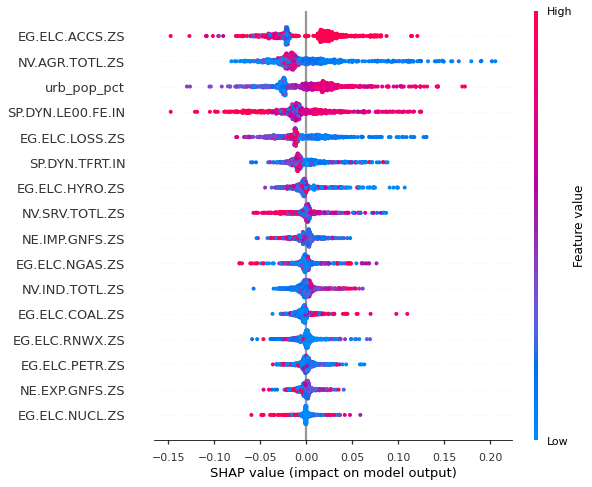

cluster_id =  2


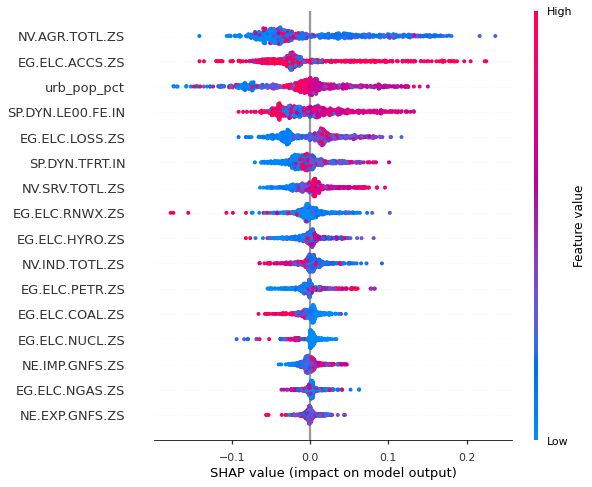

cluster_id =  3


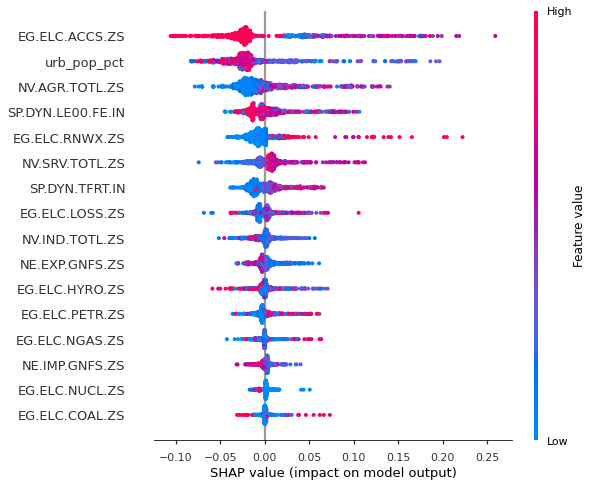

cluster_id =  4


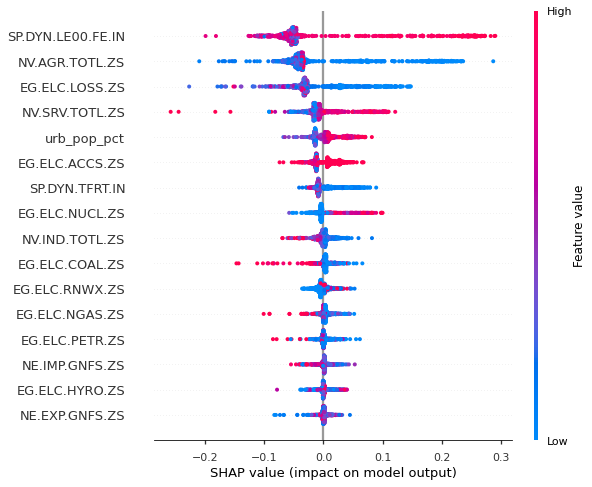

cluster_id =  5


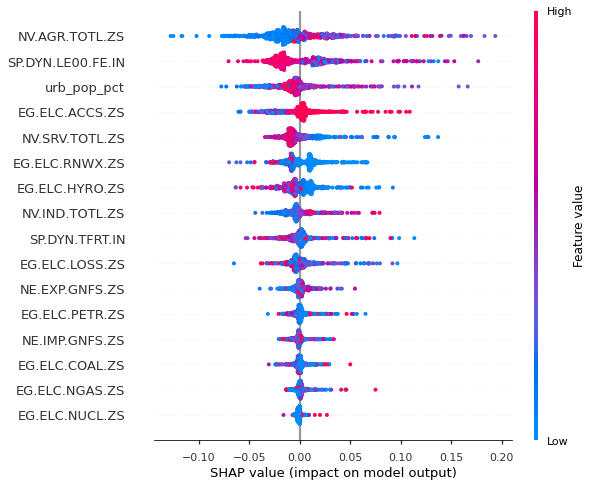

cluster_id =  6


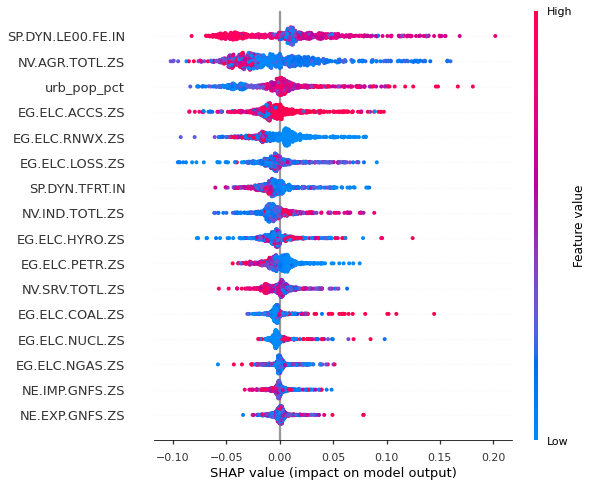

cluster_id =  7


cluster_id =  8


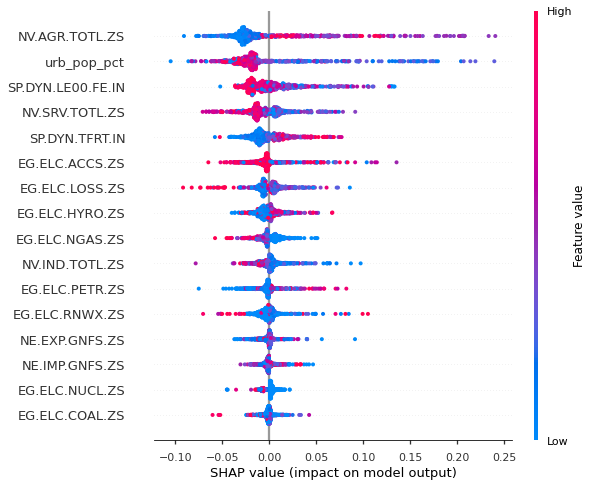

cluster_id =  9


In [38]:
for cluster in list(set(y2_test)):
    print('cluster_id = ', cluster)
    shap.summary_plot(shap_values[cluster], X2_test.values, feature_names = X2_test.columns)

In [39]:
X2_test.columns

Index(['NV.AGR.TOTL.ZS', 'SP.DYN.LE00.FE.IN', 'urb_pop_pct', 'EG.ELC.ACCS.ZS',
       'EG.ELC.LOSS.ZS', 'NV.SRV.TOTL.ZS', 'SP.DYN.TFRT.IN', 'EG.ELC.HYRO.ZS',
       'EG.ELC.RNWX.ZS', 'NV.IND.TOTL.ZS', 'EG.ELC.COAL.ZS', 'EG.ELC.NGAS.ZS',
       'EG.ELC.PETR.ZS', 'NE.EXP.GNFS.ZS', 'NE.IMP.GNFS.ZS', 'EG.ELC.NUCL.ZS'],
      dtype='object')

cluster_id =  0


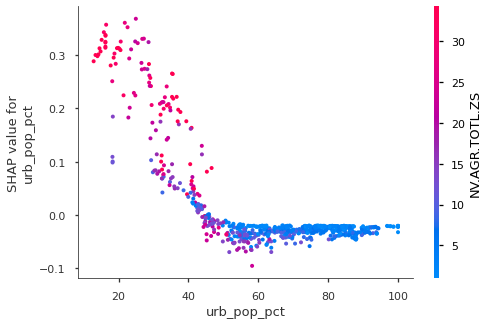

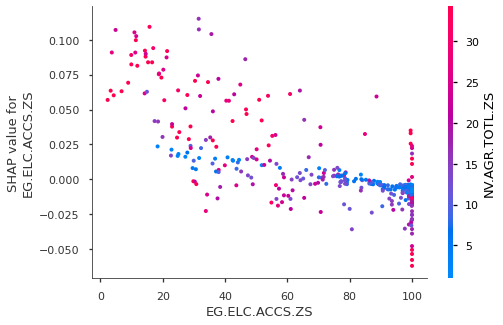

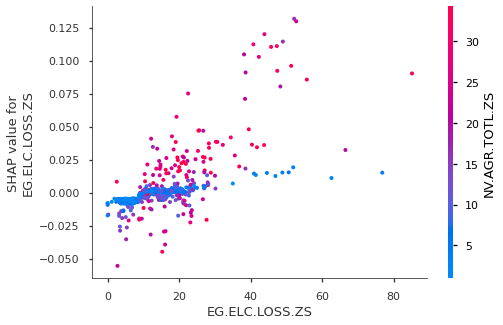

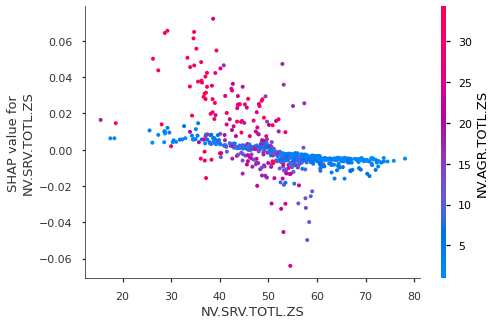

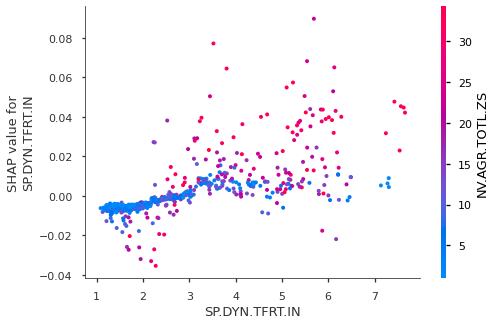

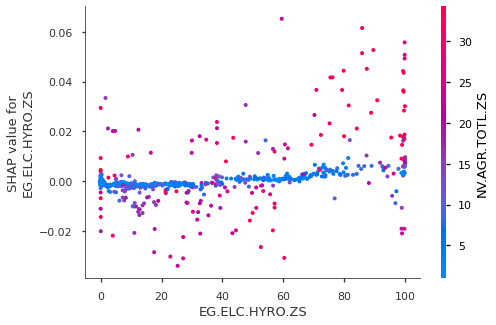

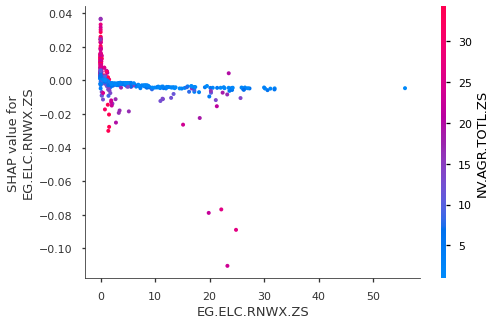

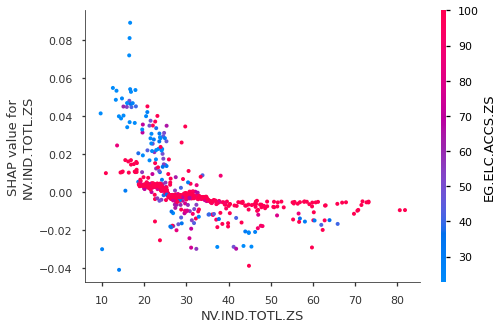

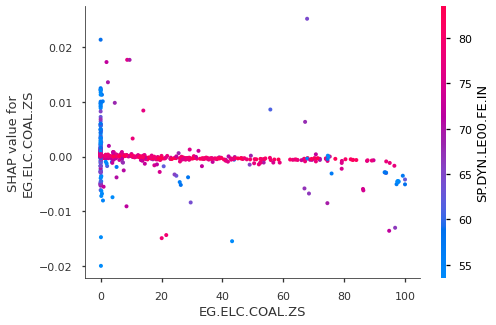

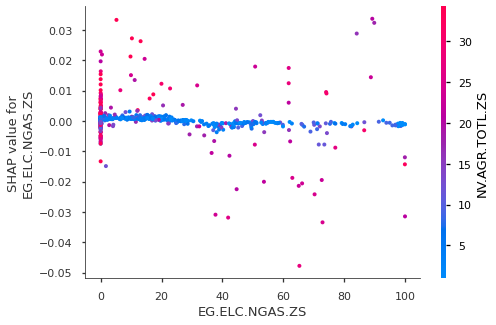

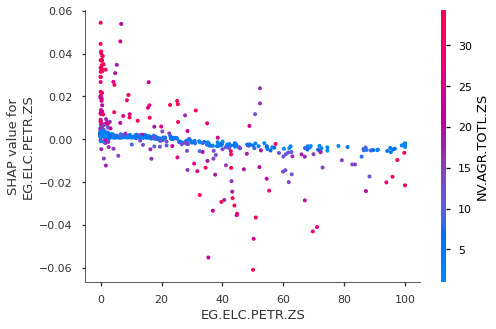

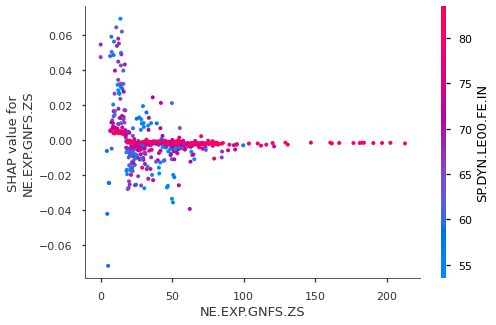

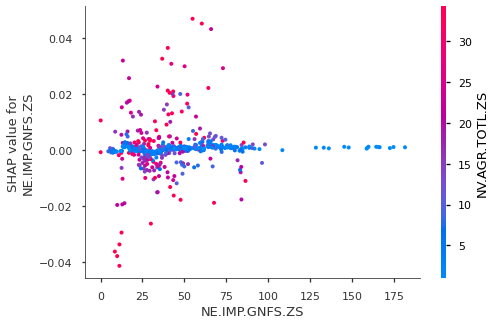

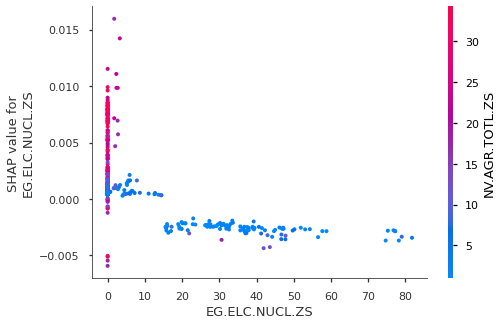

cluster_id =  1


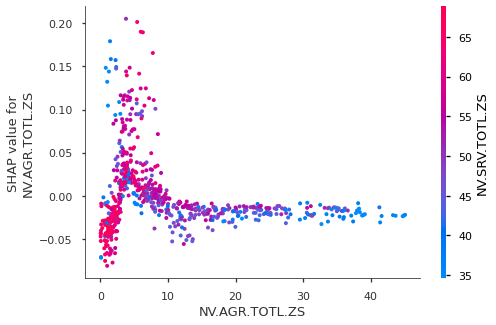

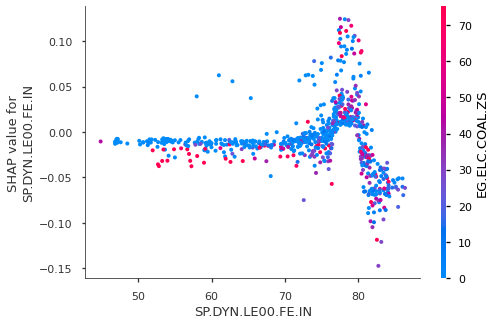

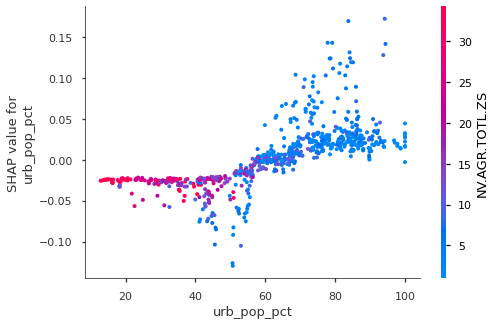

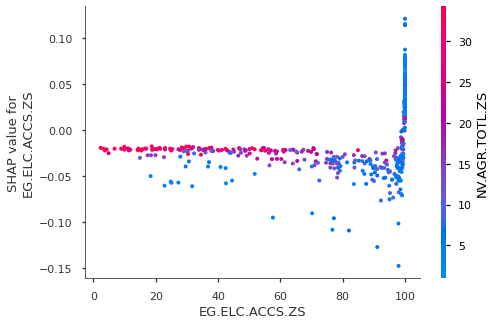

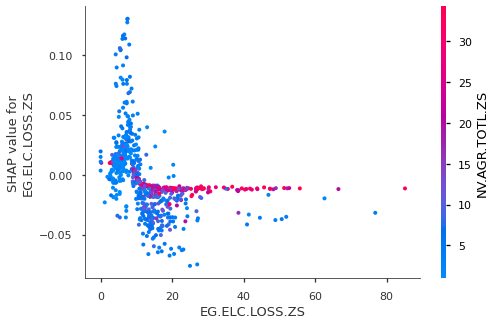

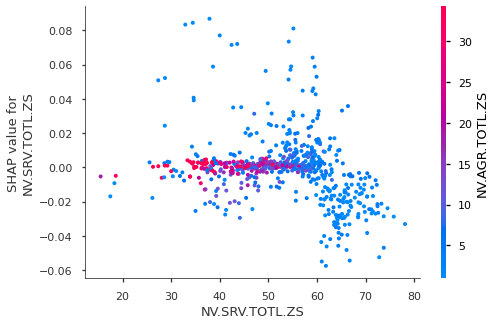

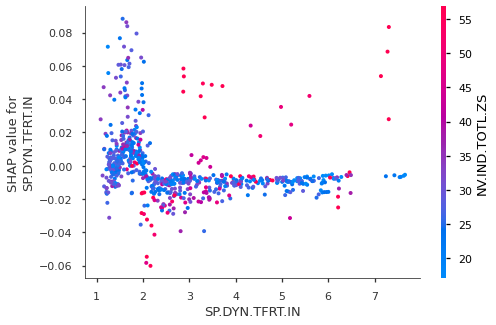

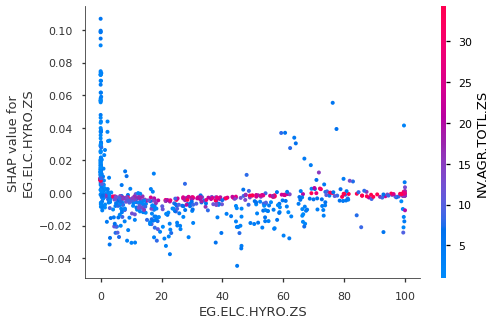

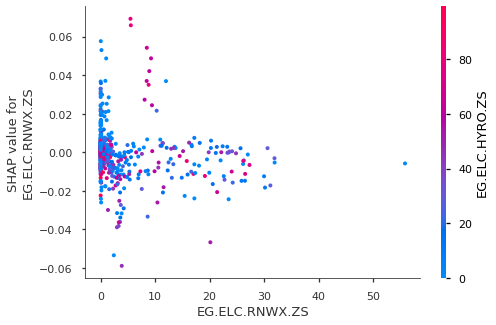

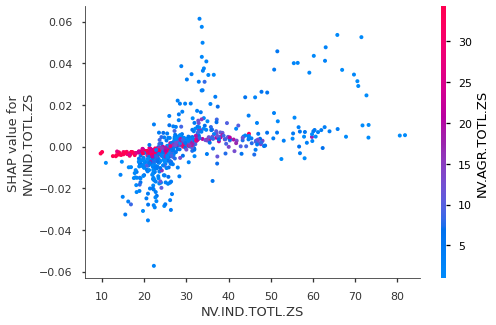

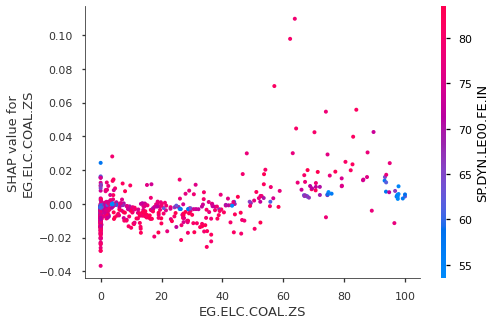

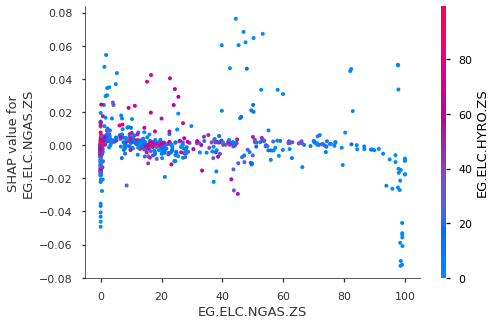

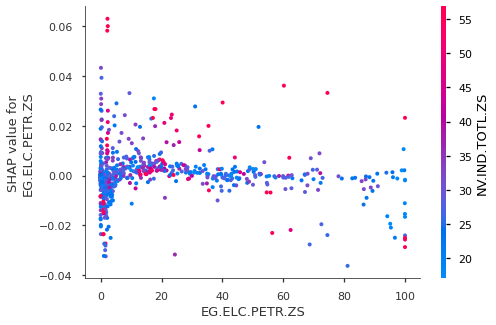

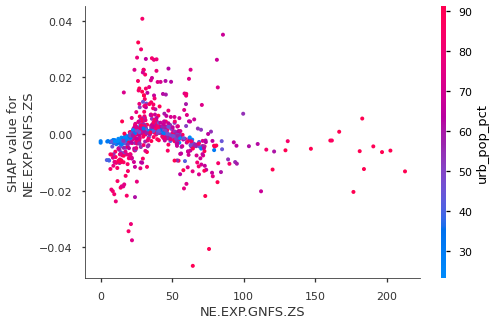

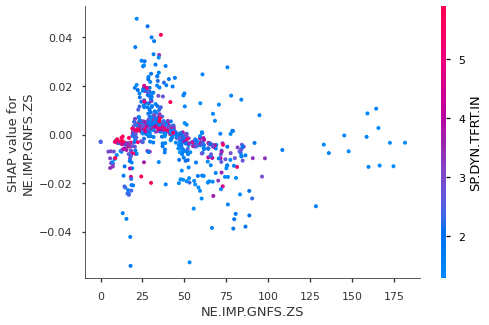

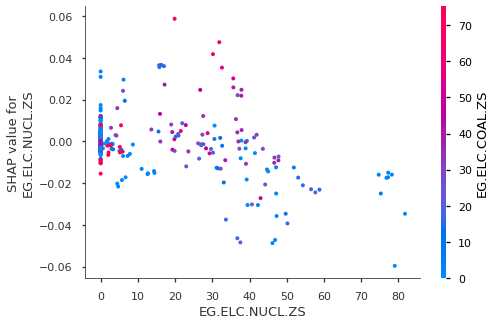

cluster_id =  2


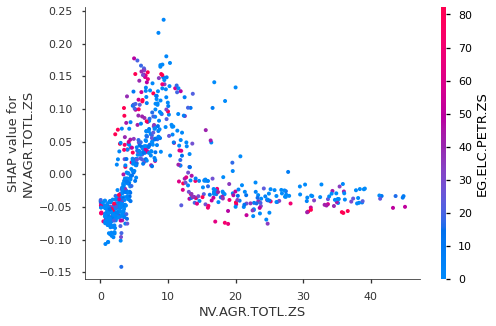

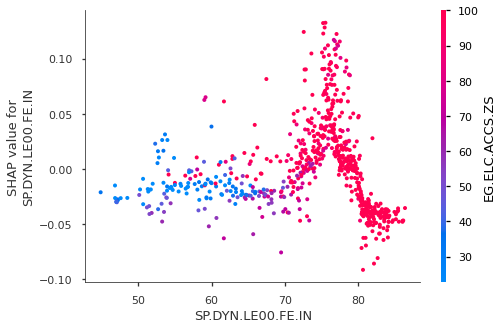

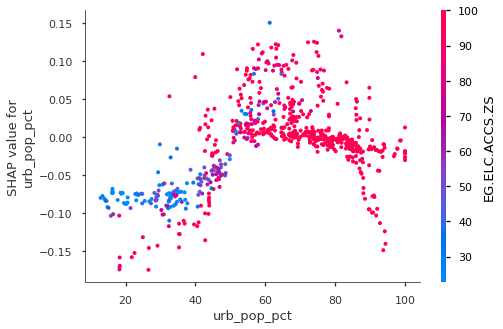

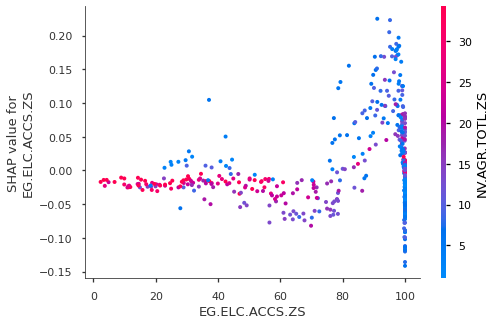

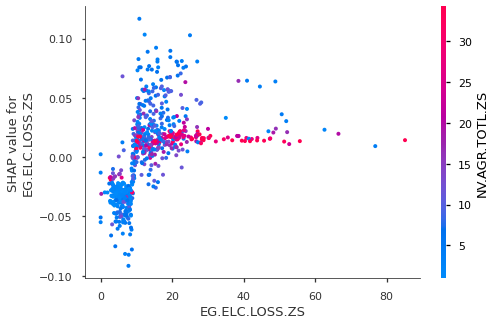

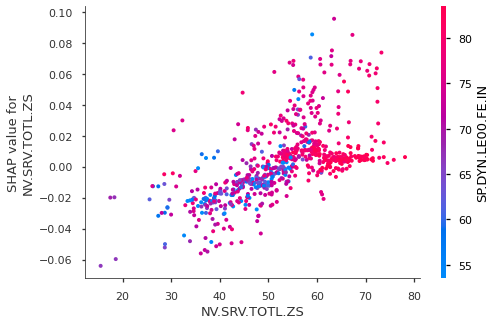

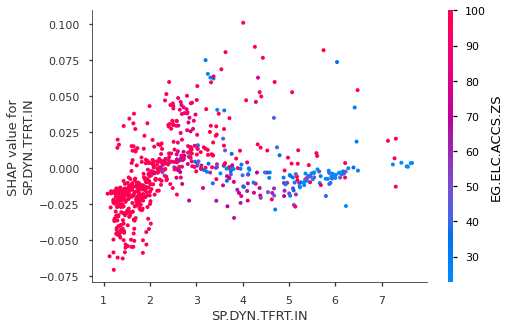

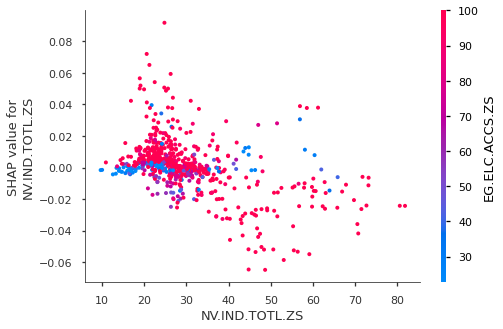

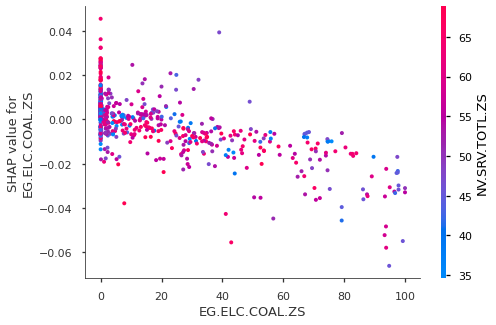

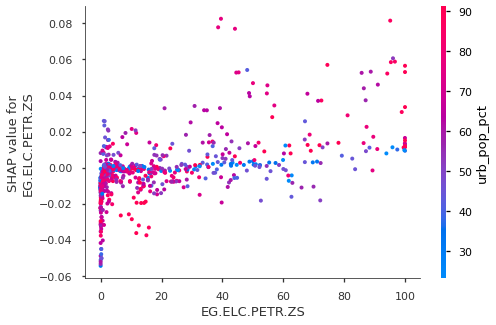

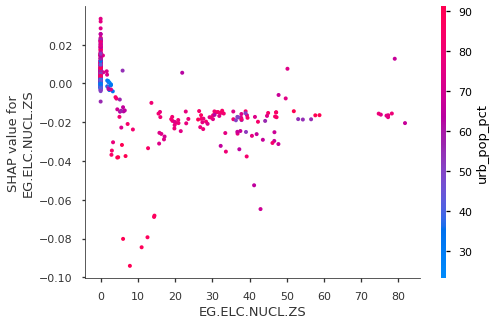

cluster_id =  3


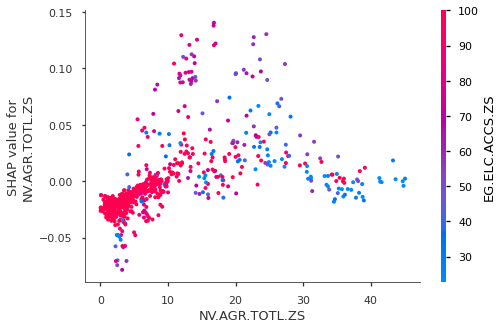

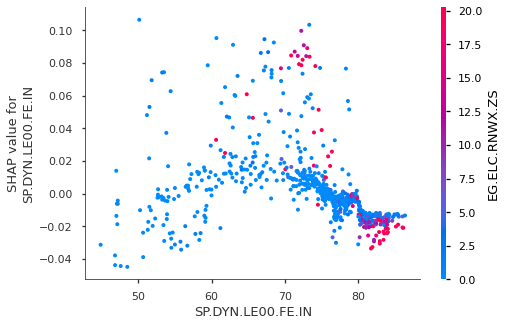

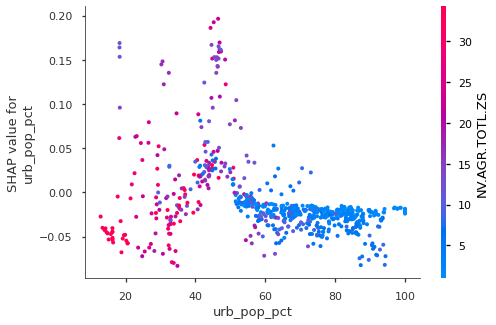

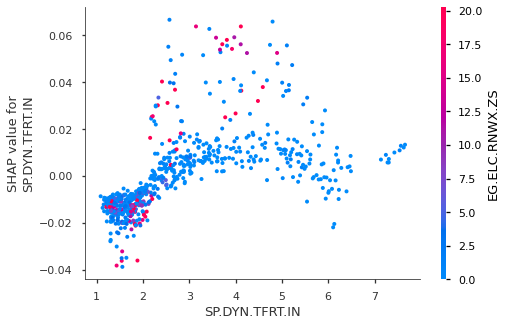

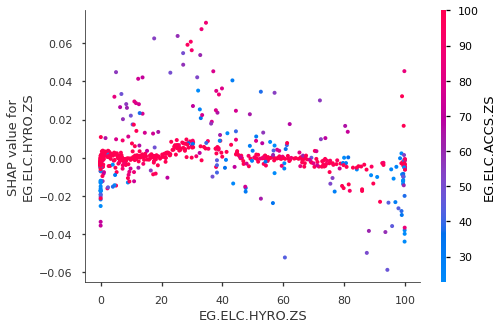

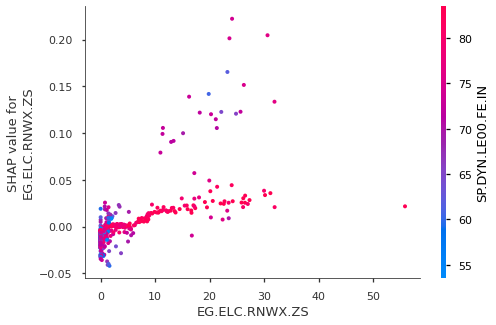

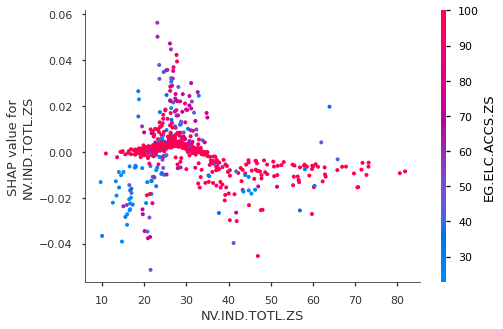

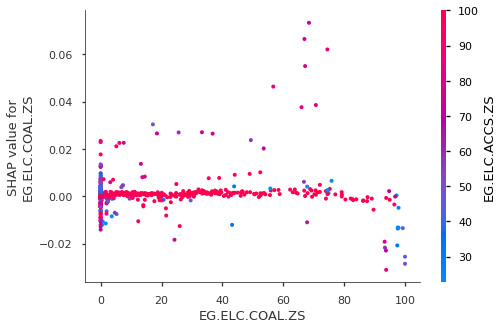

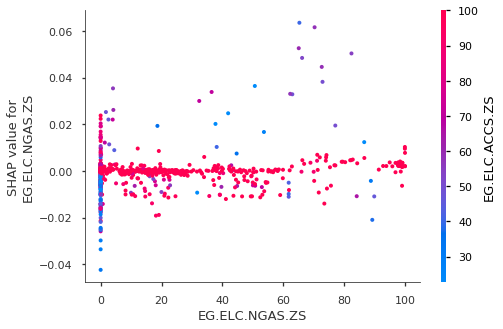

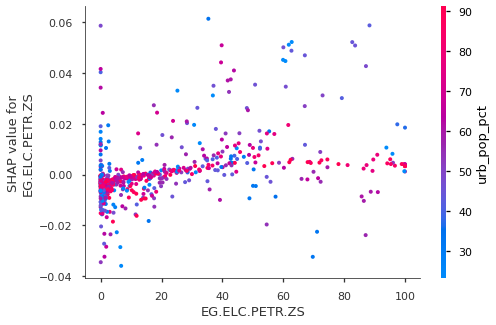

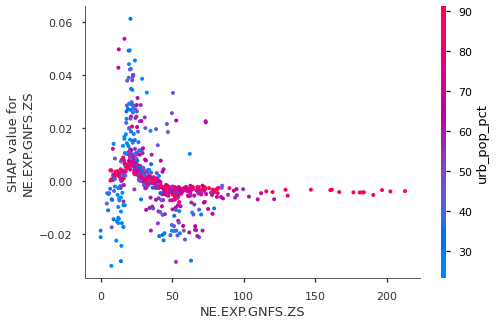

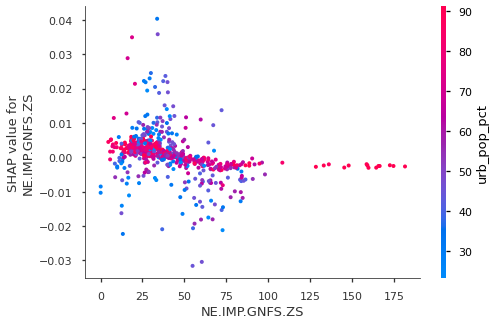

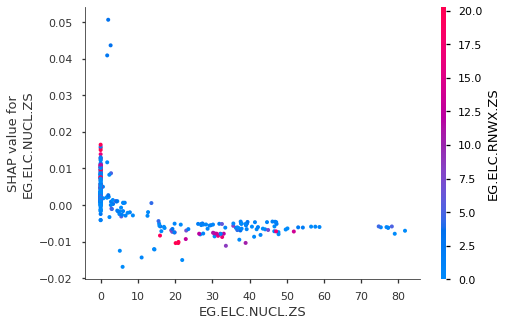

cluster_id =  4


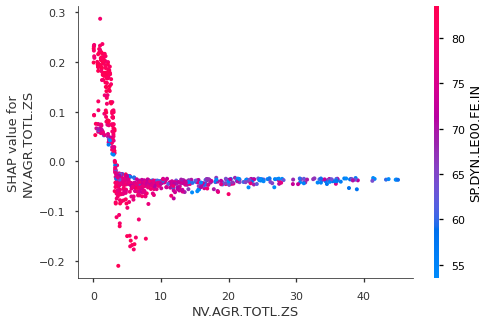

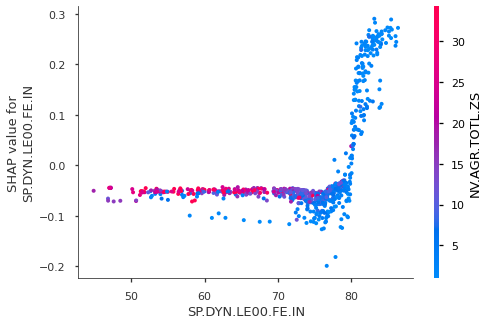

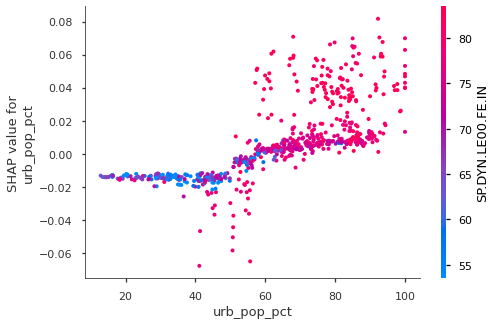

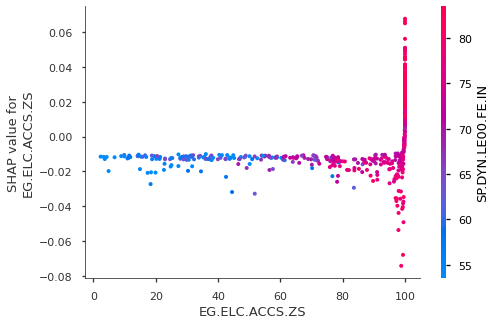

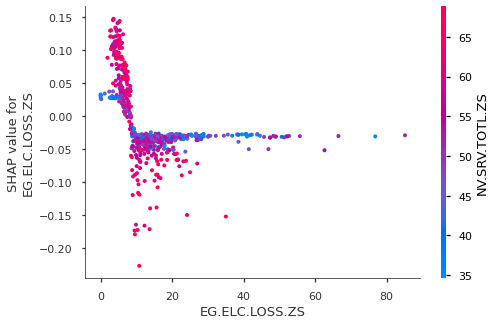

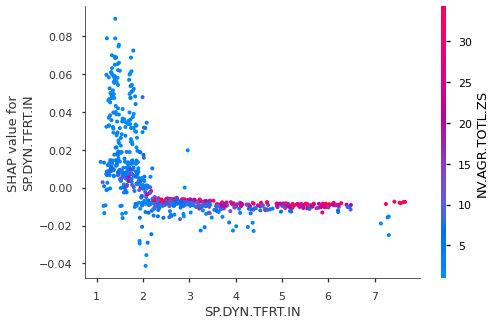

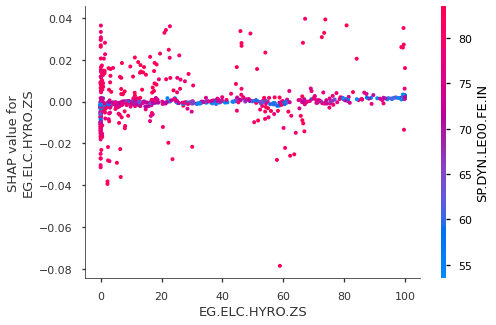

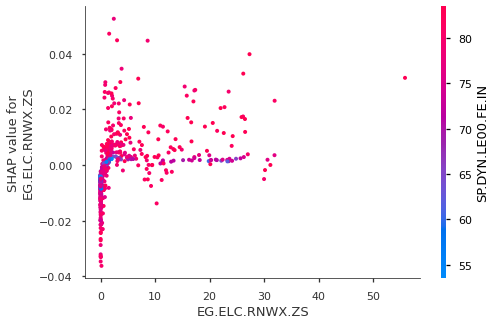

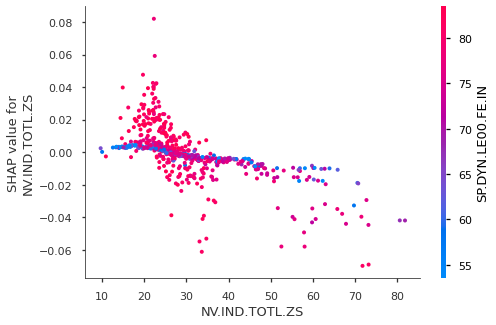

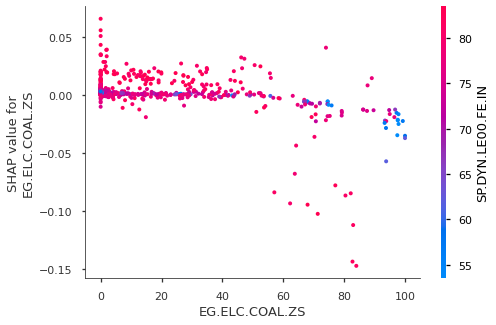

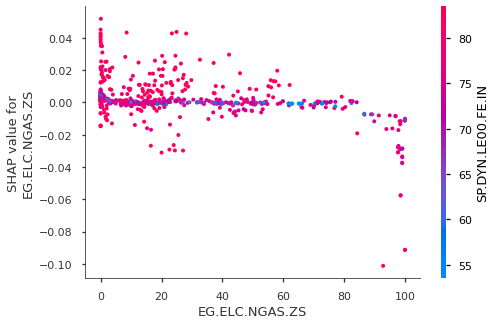

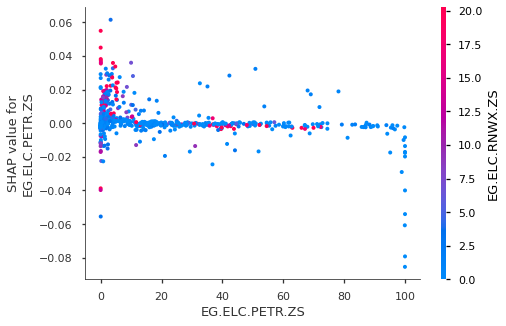

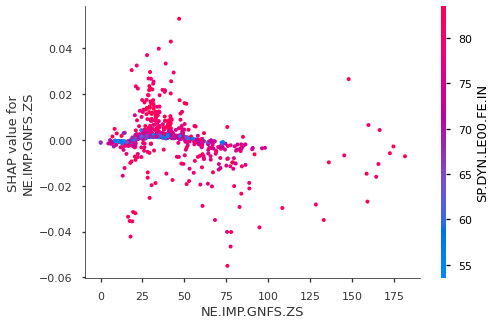

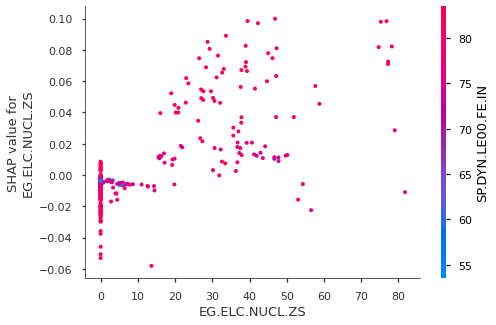

cluster_id =  5


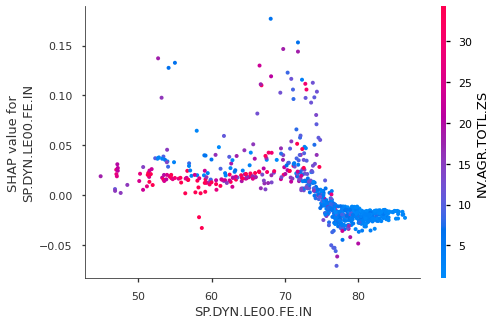

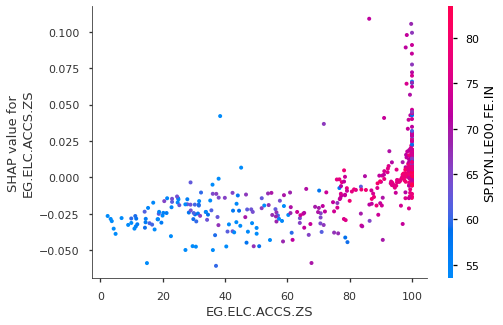

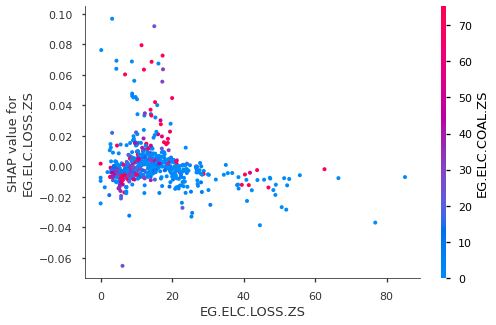

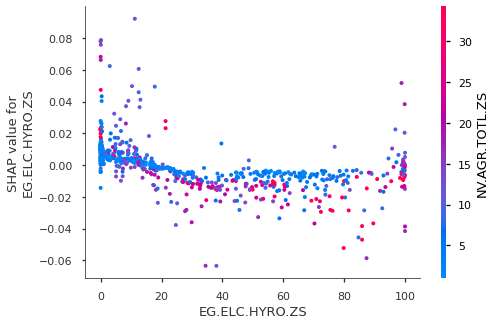

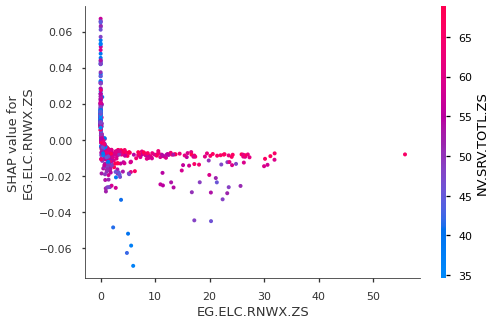

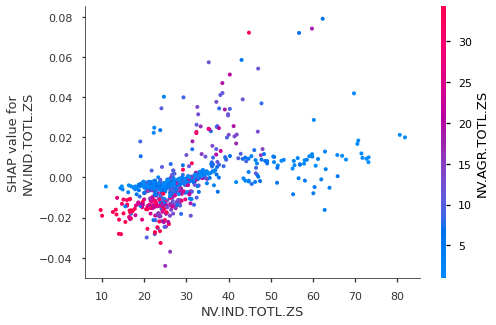

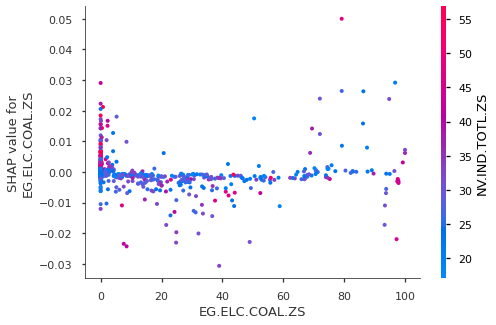

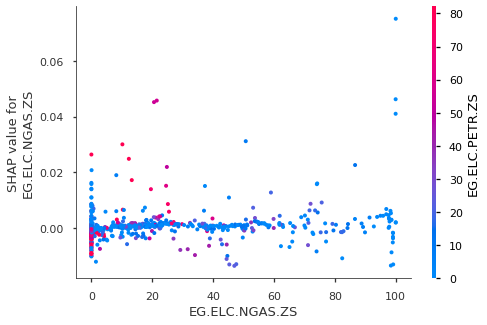

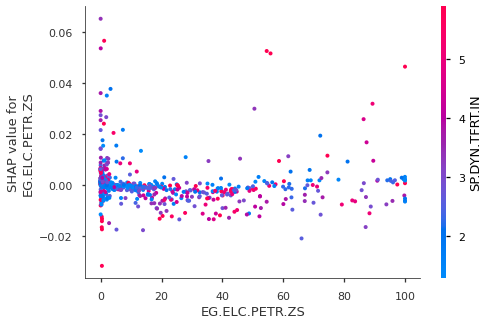

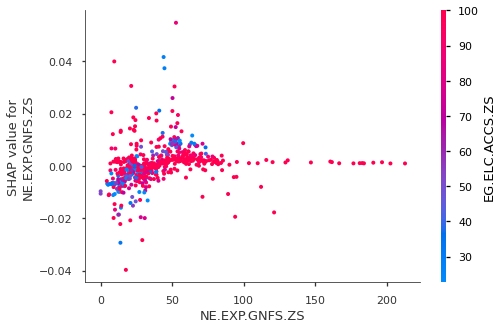

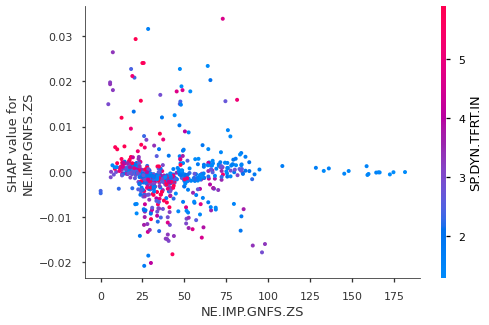

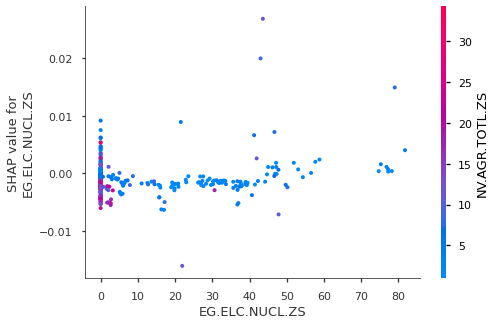

cluster_id =  6


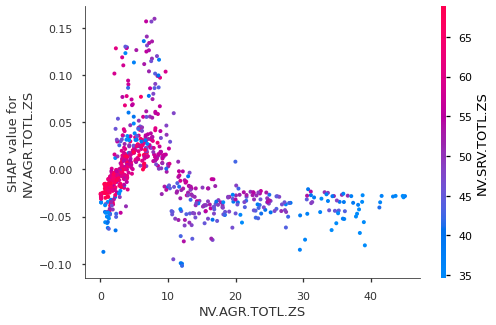

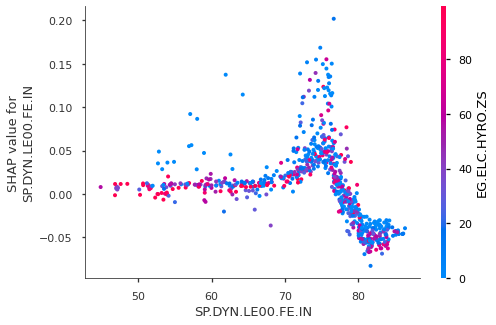

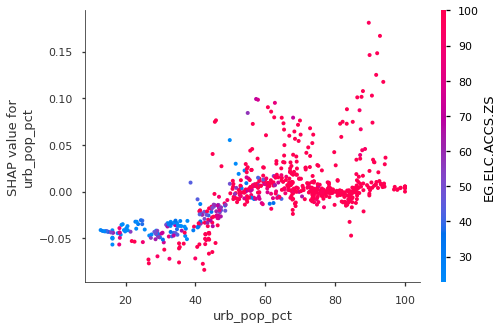

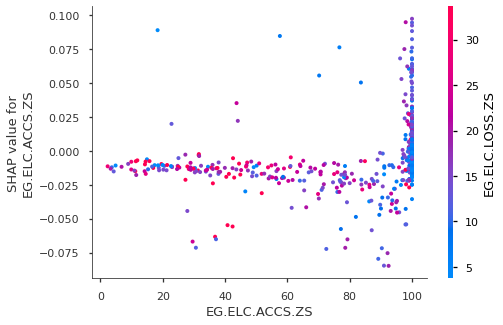

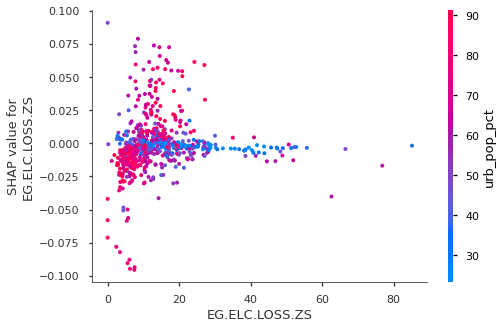

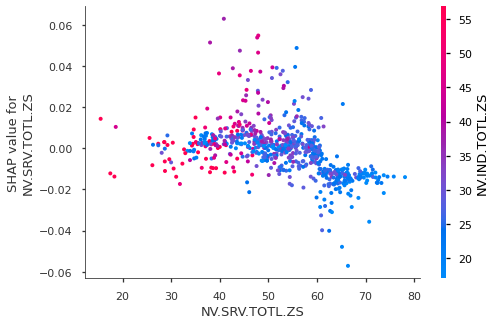

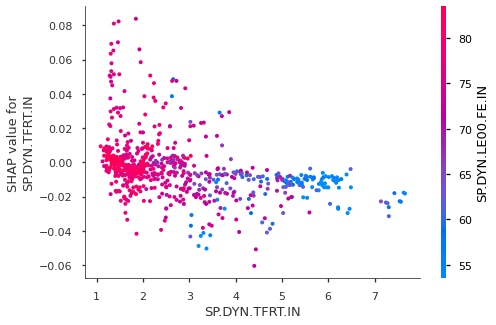

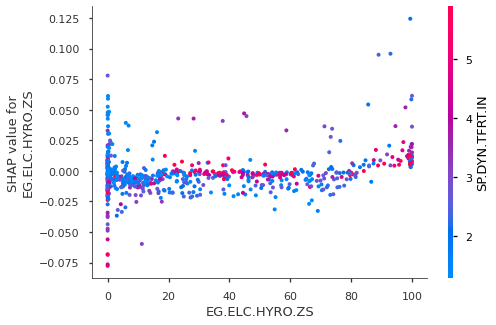

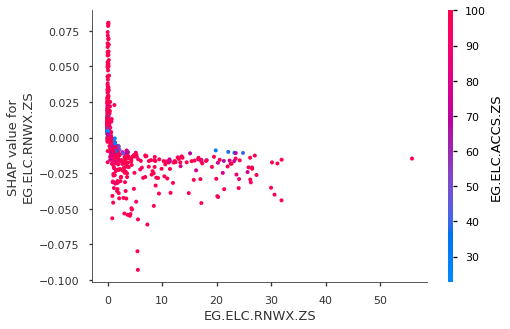

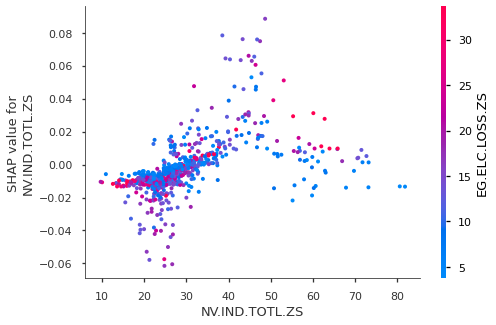

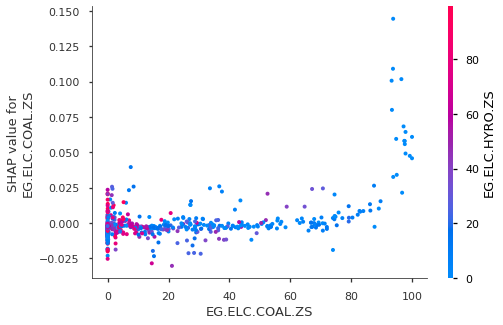

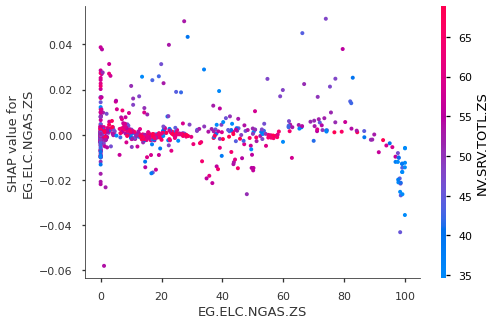

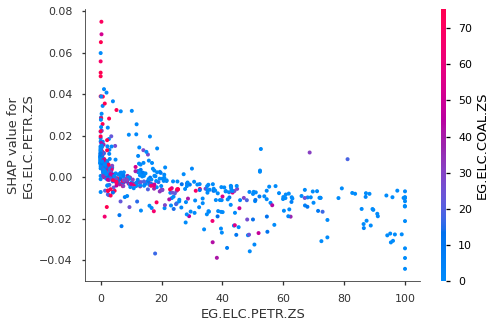

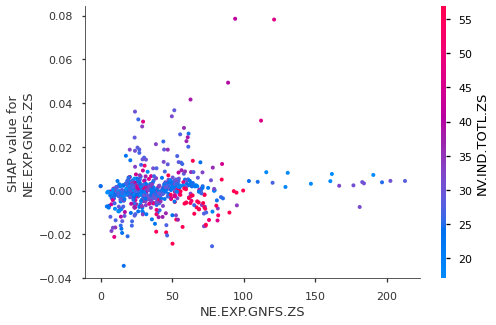

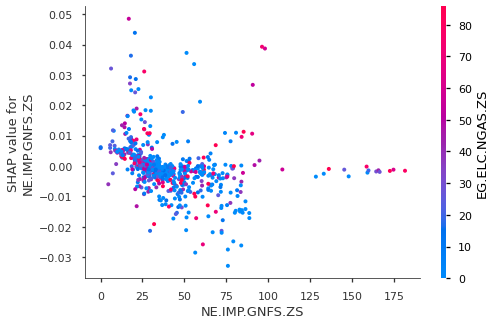

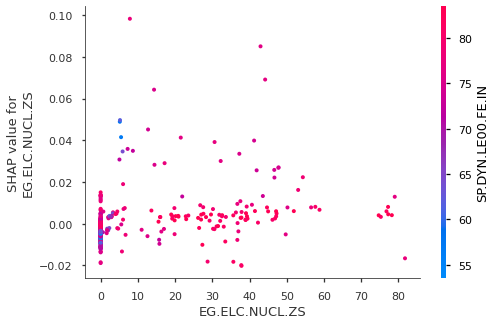

cluster_id =  7


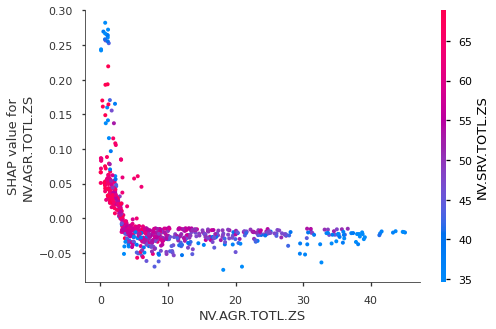

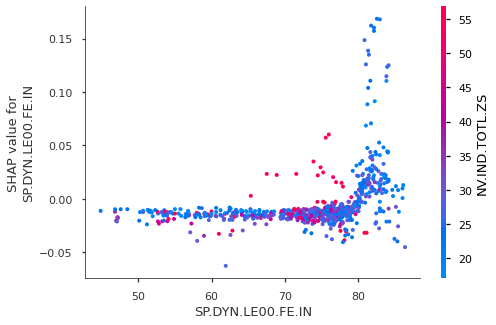

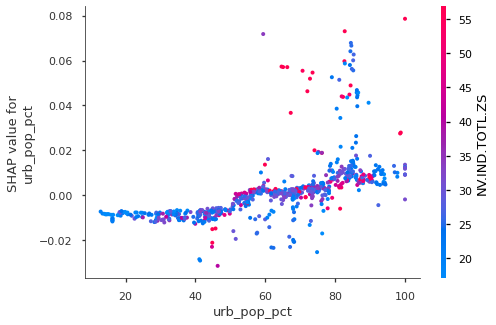

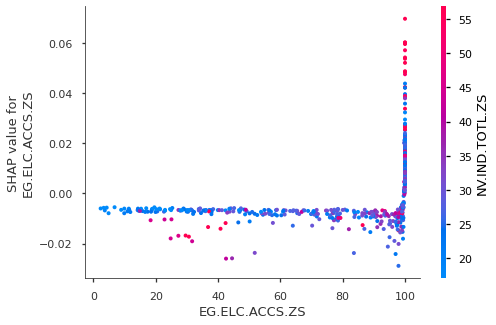

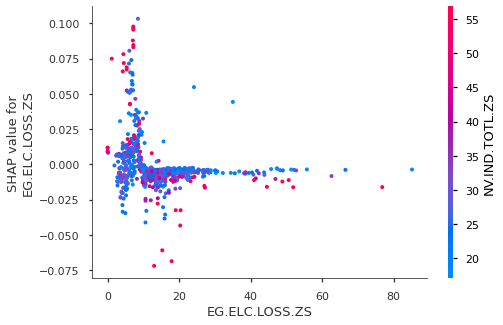

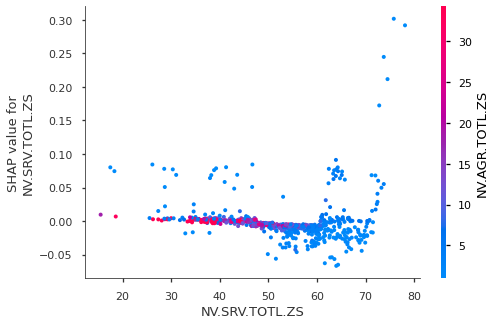

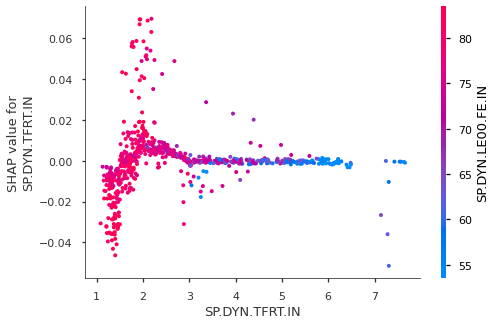

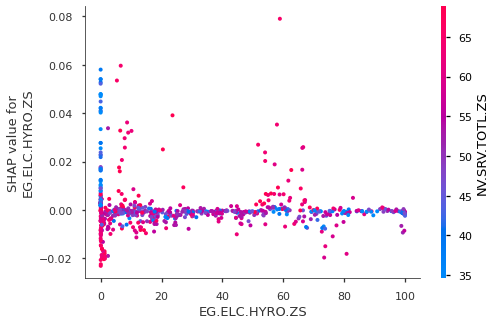

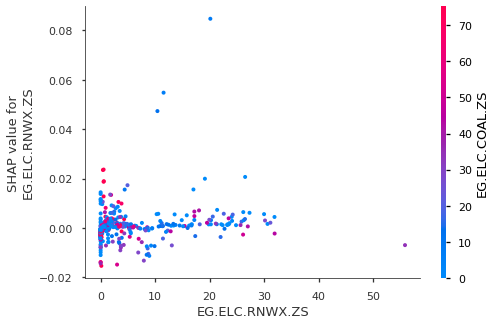

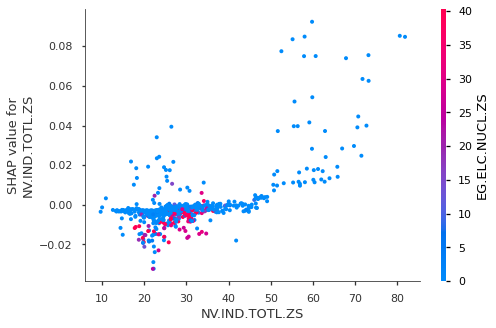

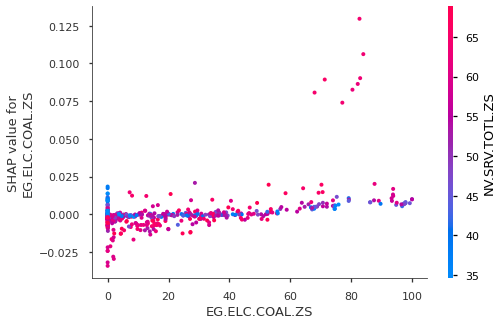

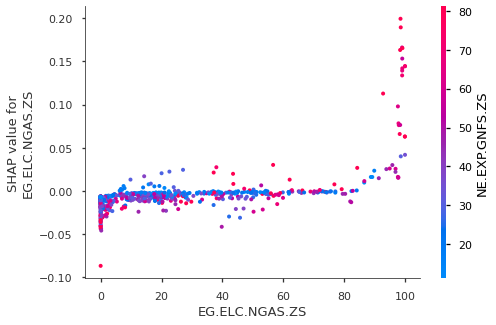

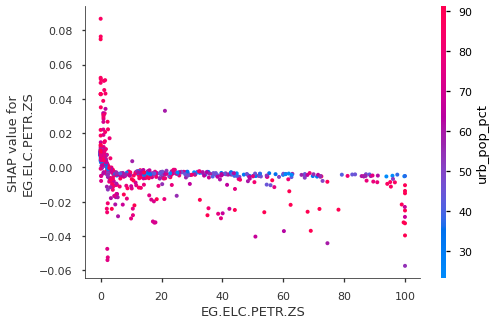

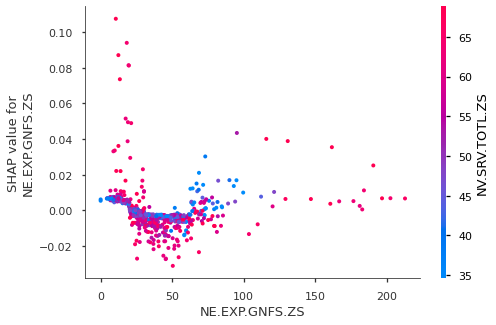

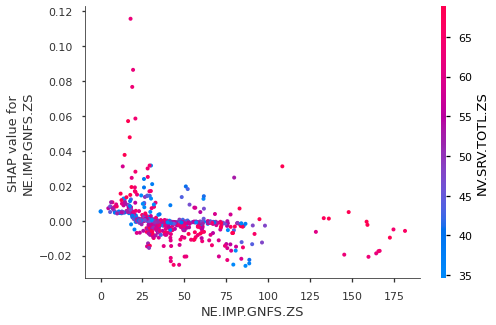

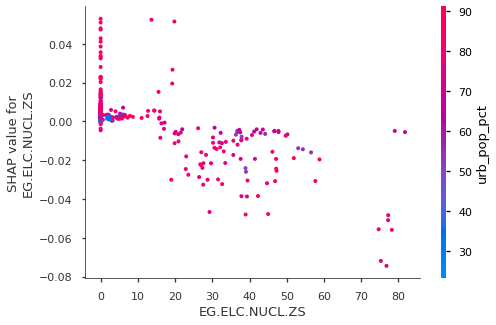

cluster_id =  8


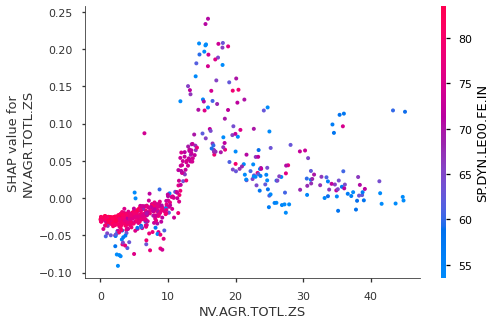

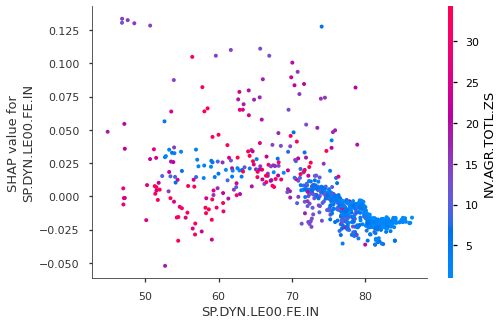

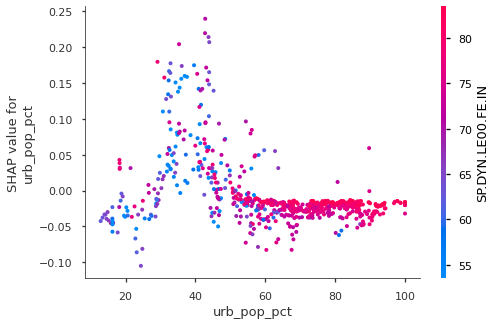

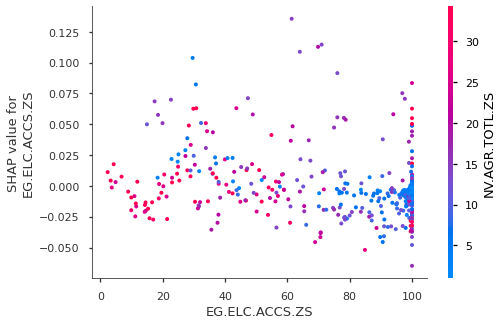

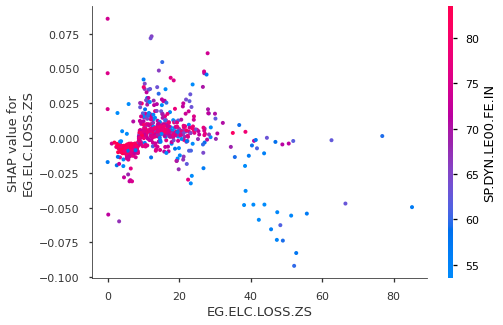

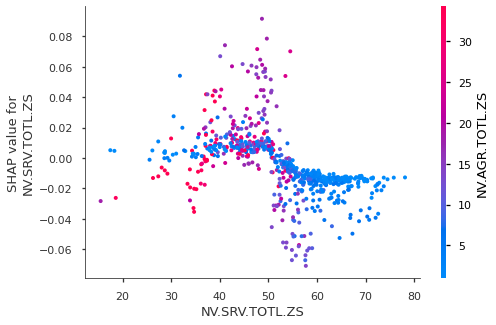

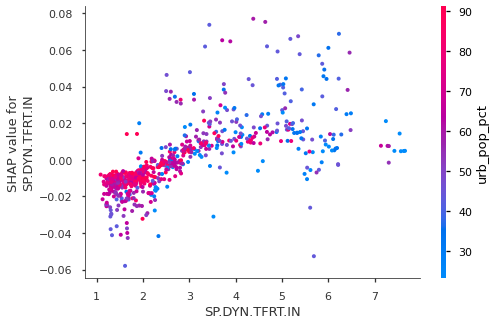

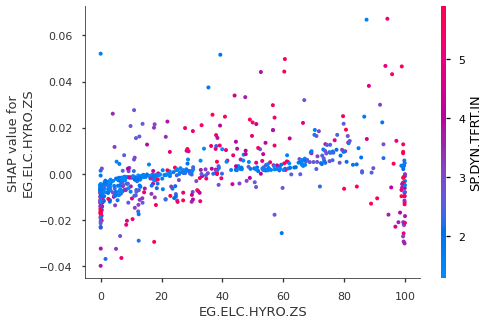

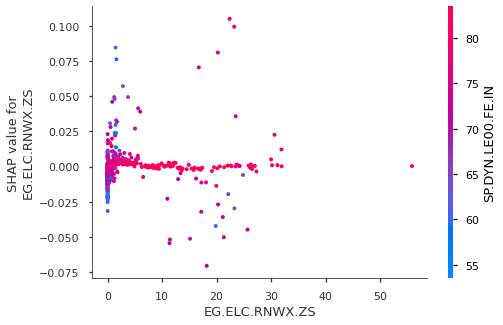

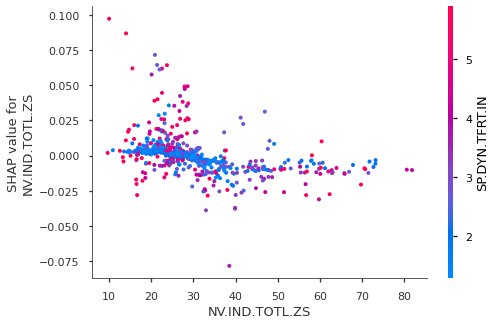

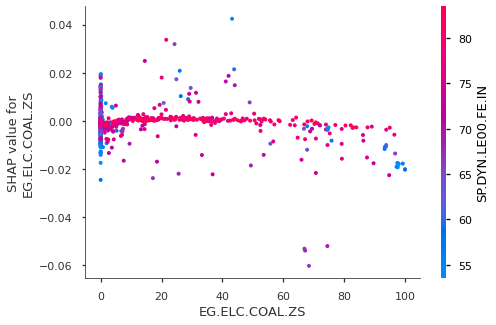

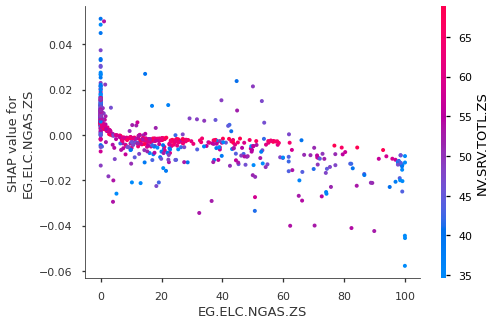

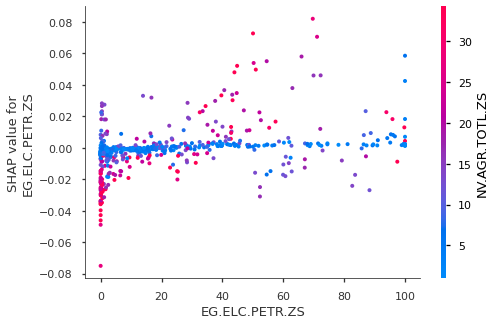

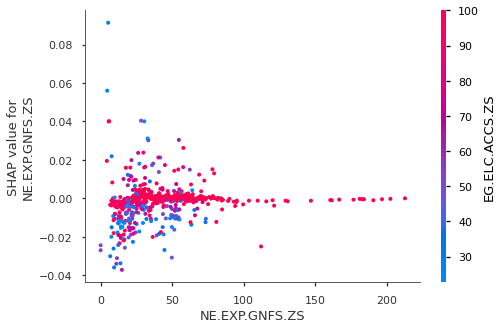

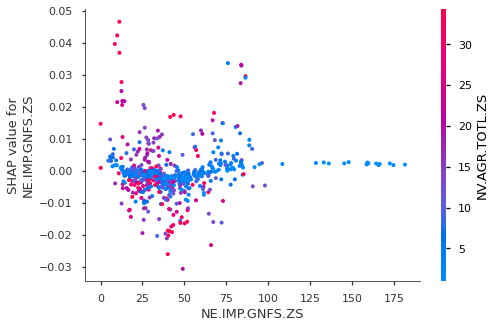

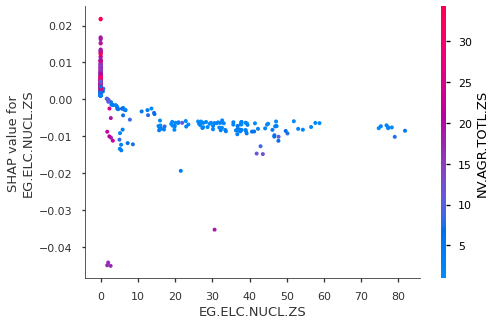

cluster_id =  9


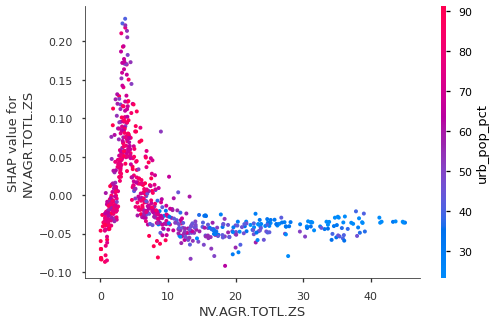

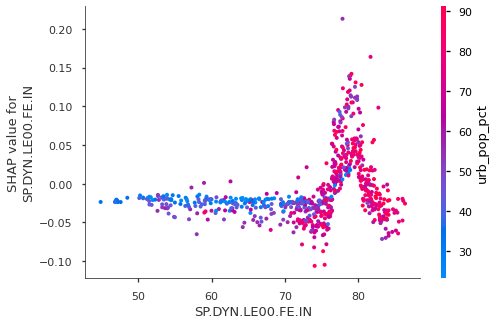

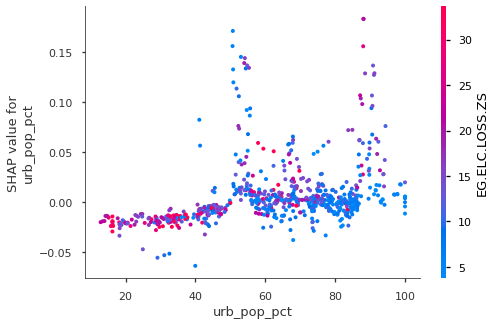

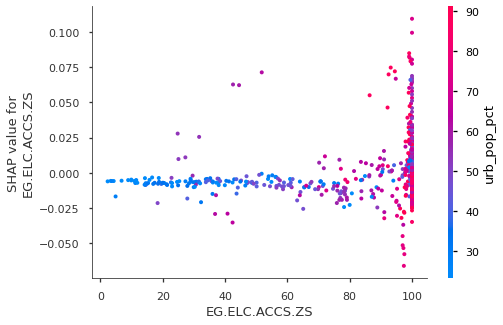

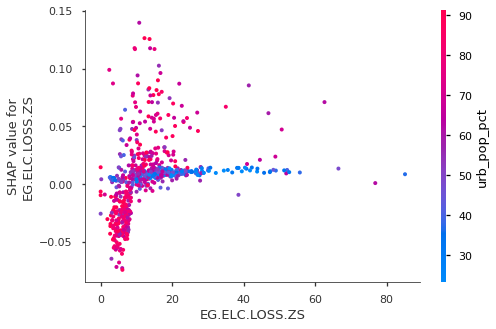

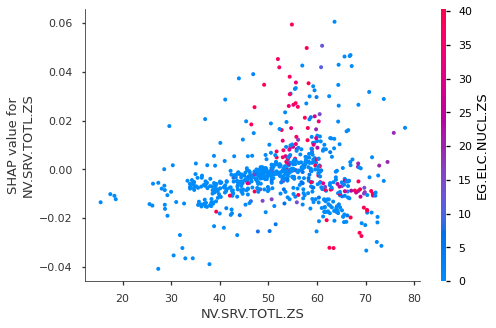

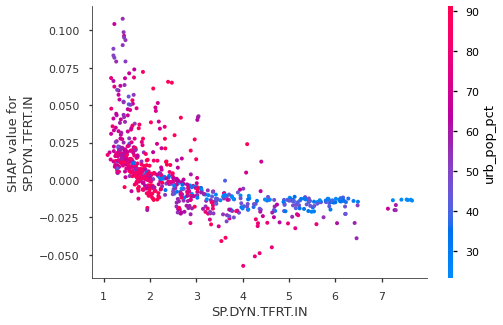

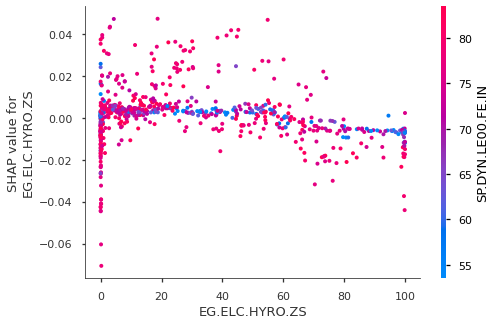

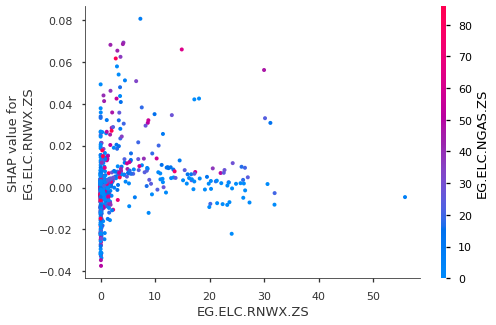

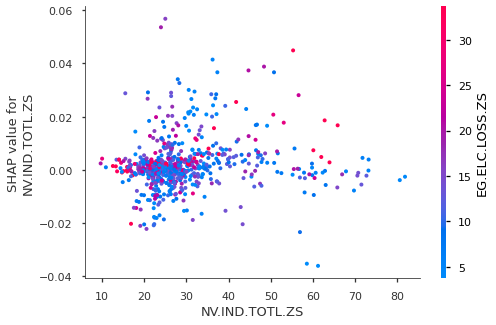

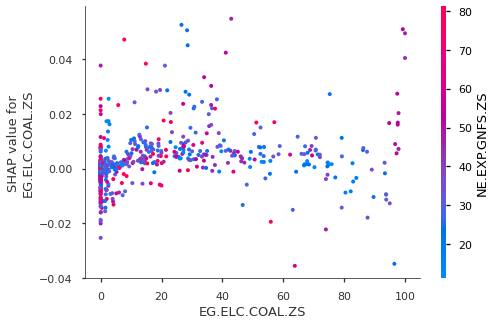

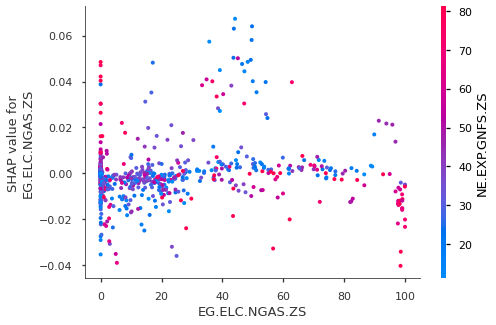

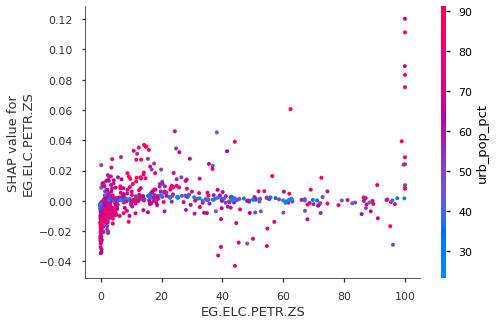

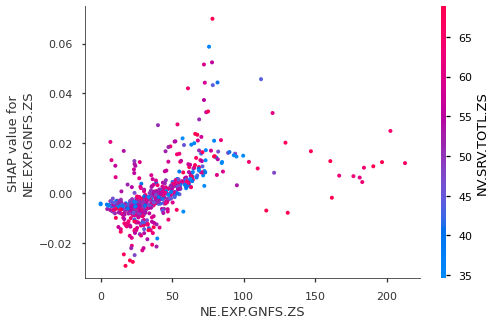

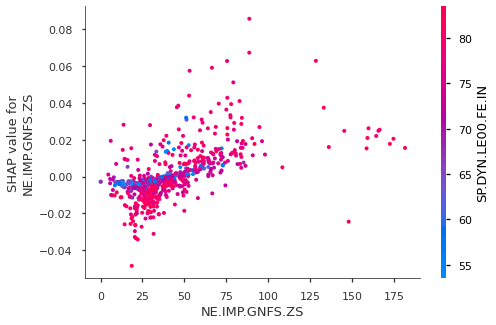

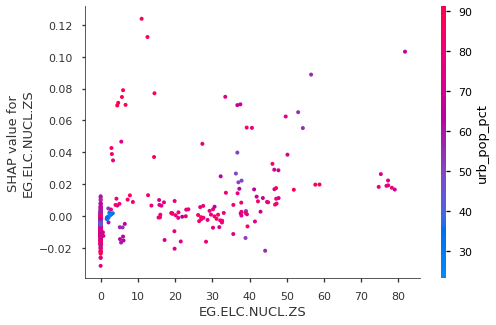

In [40]:
for cluster in list(set(y2_test)):
    print('cluster_id = ', cluster)
    for feature in range(len(X2_test.columns)):
        shap.dependence_plot(feature, shap_values[cluster], X2_test.values, feature_names = X2_test.columns)